# **Customer Churn Prediction at Telecom Interconnect**

# **Project Backrgound**

A telecommunications operator named Interconnect wants to forecast their clients' churn rates. 󠀰 Interconnect's marketing team has collected some personal data from clients, including information about selected data plans and their contracts.

**Interconnect Services**

󠀰Interconnect provides two main types of services::
1. The landline network. The telephone can be connected to several lines simultaneously.

2. Internet. The internet network can be managed via a telephone line (DSL, *digital subscriber line*) or via a fiber optic cable.

󠀰Some of the other services that Interconnect also provides, include:

- Internet security: antivirus software (DeviceProtection) and malicious website blocker (OnlineSecurity)

- Dedicated technical support line (*TechSupport*)

- *cloud* storage for *file* and *backup* data (*OnlineBackup*)

- *Streaming* TV (*StreamingTV*) and movie directories (*StreamingMovies*)

Customers can choose to pay monthly or sign a contract for a 1 or 2 year subscription.They can use various payment methods and receive electronic bills after making a transaction.

**Data Description**

The available data consists of several files obtained from different sources:

- `contract.csv` — 󠀰contract information
- `personal.csv` — 󠀰client personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about phone services

At each *file* you will find a `customerID` column with a unique code assigned to each client.

Contract information is effective as of February 1, 2020.

# **Project Goals**

Target feature: The `'EndDate'` column is the same as `'No'`.

Main metric: AUC-ROC.

Additional metrics: *Accuracy*.

Assessment criteria:

- AUC-ROC < 0.75 — 0 SP
- 0.75 ≤ AUC-ROC < 0.81 — 4 SP
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87 — 5 SP
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
- AUC-ROC ≥ 0.88 — 6 SP

# **Initialization**

In [1]:
#!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.9 MB/s eta 0:00:00


In [2]:
#!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.1 MB/s eta 0:00:00


In [161]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from tqdm.auto import tqdm
import missingno as msno

#Matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

#Scipy
from scipy import stats as st

#Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import metrics
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report, roc_auc_score, roc_curve

#LightGBM
from lightgbm import LGBMClassifier

#SpaCy
import spacy

#Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

#Others
from google.colab import files
import io

import warnings
warnings.filterwarnings('ignore')


In [162]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# the next line provides better quality graphics on a HiDPI screen

plt.style.use('default')

In [163]:
tqdm.pandas()

In [164]:
#uplaod dataset
#uploaded = files.upload()

# **1. Load Data**

In [165]:
df_contract = pd.read_csv('/content/contract.csv')
df_internet = pd.read_csv('/content/internet.csv')
df_personal = pd.read_csv('/content/personal.csv')
df_phone = pd.read_csv('/content/phone.csv')

# **1.1 Review Data Contents**

**Contract Dataset**

In [166]:
df_contract.head(2)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5


In [167]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [168]:
df_contract.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [169]:
df_contract.shape

(7043, 8)

In [170]:
df_contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
198,7255-SSFBC,2014-02-01,No,Two year,Yes,Bank transfer (automatic),112.25,8041.65
6844,6897-UUBNU,2017-09-01,No,Month-to-month,No,Mailed check,89.65,2623.65
6358,1027-LKKQQ,2014-02-01,No,Two year,Yes,Bank transfer (automatic),80.45,5886.85
5855,2338-BQEZT,2015-07-01,No,Month-to-month,Yes,Credit card (automatic),50.55,2832.75
5140,7577-SWIFR,2020-01-01,No,Month-to-month,Yes,Electronic check,89.25,89.25


In [171]:
df_contract.describe(percentiles=[.1, .05, .25, .75, .95, .99]).round(1).T

,count,mean,std,min,5%,10%,25%,50%,75%,95%,99%,max
MonthlyCharges,7043.0,64.8,30.1,18.2,19.6,20.0,35.5,70.4,89.8,107.4,114.7,118.8


In [172]:
df_contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

**Conclusion**

Here are the findings on the `df_contract` dataset

- There are 7043 rows of data, and 8 columns
- Has a **mean** by 64.8 on `MonthlyCharges`
- Has a **median** by 70.4 in `MonthlyCharges`
- The smallest `MonthlyCharges` is 18.2
- The largest `MonthlyCharges` is 118.8
- `Type` contracts are divided into 3 types:
   - **Month-to-month** by 3875
   - **Two year** by 1695
   - **One year** by 1473
- There is no missing values (NULL) has been found

**Internet Dataset**

In [173]:
df_internet.head(2)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


In [174]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [175]:
df_internet.isnull().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [176]:
df_internet.shape

(5517, 8)

In [177]:
df_internet.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4155,1935-IMVBB,Fiber optic,No,No,No,No,Yes,Yes
5237,2027-CWDNU,Fiber optic,No,No,No,Yes,No,Yes
4680,3462-BJQQA,Fiber optic,No,Yes,No,No,Yes,No
3805,5923-GXUOC,Fiber optic,Yes,Yes,Yes,No,Yes,Yes
4419,4471-KXAUH,Fiber optic,No,No,Yes,Yes,No,No


In [178]:
df_internet.describe(percentiles=[.1, .05, .25, .75, .95, .99]).round(1).T

,count,unique,top,freq
customerID,5517,5517,7590-VHVEG,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


In [179]:
df_internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [180]:
df_internet['OnlineSecurity'].value_counts()

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

In [181]:
df_internet['OnlineBackup'].value_counts()

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

In [182]:
df_internet['DeviceProtection'].value_counts()

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

In [183]:
df_internet['TechSupport'].value_counts()

No     3473
Yes    2044
Name: TechSupport, dtype: int64

In [184]:
df_internet['StreamingTV'].value_counts()

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

In [185]:
df_internet['StreamingMovies'].value_counts()

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

**Conclusion**

Here are the findings on the `df_internet` dataset

- There are 5517 rows of data, and 8 columns
- `InternetService` has data with a `Fiber optic` value by 3096, and a `DSL` value by 2421. So the customers with the most `InternetService` services are those using **Fiber optic**
- In other columns, there are also many `No` values in columns such as `OnlineSecurity`, `OnlineBackup`, etc. It can be concluded that the majority of customers do not use the service.
- There is no missing values (NULL) has been found

**Personal Dataset**

In [186]:
df_personal.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No


In [187]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [188]:
df_personal.isnull().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [189]:
df_personal.shape

(7043, 5)

In [190]:
df_personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
1975,4703-MQYKT,Male,0,No,No
6641,2810-FTLEM,Female,0,No,No
3521,2550-AEVRU,Female,0,Yes,Yes
6494,4310-KEDTB,Female,0,No,Yes
97,0278-YXOOG,Male,0,No,No


In [191]:
df_personal.describe(percentiles=[.1, .05, .25, .75, .95, .99]).round(1).T

,count,mean,std,min,5%,10%,25%,50%,75%,95%,99%,max
SeniorCitizen,7043.0,0.2,0.4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [192]:
df_personal[df_personal['SeniorCitizen'] == 1].groupby('gender')['SeniorCitizen'].value_counts()

gender  SeniorCitizen
Female  1                568
Male    1                574
Name: SeniorCitizen, dtype: int64

In [193]:
df_personal[df_personal['SeniorCitizen'] == 1].groupby('Partner')['SeniorCitizen'].value_counts()

Partner  SeniorCitizen
No       1                569
Yes      1                573
Name: SeniorCitizen, dtype: int64

In [194]:
df_personal[df_personal['SeniorCitizen'] == 1].groupby('Dependents')['SeniorCitizen'].value_counts()

Dependents  SeniorCitizen
No          1                1051
Yes         1                  91
Name: SeniorCitizen, dtype: int64

**Conclusion**

Here are the findings on the `df_personal` dataset

- There are 7043 rows of data, and 5 columns
- `SeniorCitizen` has data with **Female** gender by 568. And Gender **Male** by 574.
- In other columns, there is also many `No` values in the `Dependents` column. It can be concluded that the majority of customers do not have dependents (children, etc.) in their families.
- There is no missing values (NULL) has been found

**Phone Dataset**

In [195]:
df_phone.head(2)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No


In [196]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [197]:
df_phone.isnull().sum()

customerID       0
MultipleLines    0
dtype: int64

In [198]:
df_phone.shape

(6361, 2)

In [199]:
df_phone.sample(5)

,customerID,MultipleLines
1932,8984-HPEMB,Yes
3332,1545-JFUML,Yes
1491,8883-ANODQ,Yes
592,4160-AMJTL,No
1052,5334-JLAXU,Yes


In [200]:
df_phone.describe(percentiles=[.1, .05, .25, .75, .95, .99]).round(1).T

,count,unique,top,freq
customerID,6361,6361,5575-GNVDE,1
MultipleLines,6361,2,No,3390


In [201]:
df_phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

**Conclusion**

Here are the findings on the `df_phone` dataset

- There are 7043 rows of data, and 5 columns
- `MultipleLines` has data with a **No** value by 3,390. And a **Yes** value by 2,971. It can be concluded that the majority of customers do not have multiple lines for the services that they used.
- There is no missing values (NULL) has been found

# **1.2 Ensure the data type is correct**

**Data type conversion on df_contract dataset**

In [202]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [203]:
df_contract.dtypes

customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

In [204]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [205]:
#Convert the incorrect data types

df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='%Y-%m-%d')
#Convert 'No' value to NaT
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], errors='coerce')

#Convert ' ' value to NaN
df_contract['TotalCharges'] = df_contract['TotalCharges'].replace(' ', np.nan).astype(float)


In [206]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [207]:
df_contract[df_contract['TotalCharges'].isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


**Conclusion**

The changes were made to `df_contract` are as follows:

- Changed the data type of the `BeginDate` column to `datetime`.
- Changed the data type of the `EndDate` column to `datetime`. However, an error was found because there was a **No** value. Then change this **No** value with **NaT** so that the column can be converted to `datetime`.
- Changed the data type of the `TotalCharges` column to `float`. However, an error was found because there is a value '[space]'. then change the value '[space]' to **NaN** or **NULL**.


**Data type conversion on df_internet dataset**

In [208]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [209]:
df_internet.dtypes

customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object

In [210]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


**Conclusion**

There is no changes need to be made for`df_internet`

**Data type conversion on df_personal dataset**

In [211]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [212]:
df_personal.dtypes

customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object

In [213]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


**Conclusion**

There is no changes need to be made for`df_personal`

**Data type conversion on df_phone dataset**

In [214]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [215]:
df_phone.dtypes

customerID       object
MultipleLines    object
dtype: object

In [216]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Conclusion**

There is no changes need to be made for `df_phone`

# **1.3 Join all tables into a dataset**

In [217]:
# Join all table
df_final_provider = df_contract.merge(df_internet, on='customerID', how='outer')
df_final_provider = df_final_provider.merge(df_personal, on='customerID', how='outer')
df_final_provider = df_final_provider.merge(df_phone, on='customerID', how='outer')
df_final_provider.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [218]:
df_final_provider.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingMovies   5517 n

**Conclusion**

There is some missing value in the following column. In the next step, it will be considered to fill the column with a certain value.
- `InternetService`
- `OnlineSecurity`
- `OnlineBackup`
- `DeviceProtection`
- `TechSupport`
- `StreamingTV`
- `StreamingMovies`

# **1.4 Check and fill the missing value**

**Check missing values for all columns in the df_internet dataset**

In [219]:
# Check the column from df_internet which has a NULL value
columns_to_check = [
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies"
]

In [220]:
df_check = df_final_provider[df_final_provider[columns_to_check].isnull().any(axis=1)]
df_check

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
11,7469-LKBCI,2018-10-01,NaT,Two year,No,Credit card (automatic),18.95,326.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,No,No
16,8191-XWSZG,2015-10-01,NaT,One year,No,Mailed check,20.65,1022.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,No,No,No
21,1680-VDCWW,2019-02-01,NaT,One year,No,Bank transfer (automatic),19.80,202.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,No,No
22,1066-JKSGK,2019-11-01,2019-12-01,Month-to-month,No,Mailed check,20.15,20.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,No,No
33,7310-EGVHZ,2020-01-01,NaT,Month-to-month,No,Bank transfer (automatic),20.20,20.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7017,4807-IZYOZ,2015-11-01,NaT,Two year,No,Bank transfer (automatic),20.65,1020.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,No,No,No
7019,9710-NJERN,2016-11-01,NaT,Two year,No,Mailed check,20.15,826.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,No,No,No
7020,9837-FWLCH,2019-02-01,NaT,Month-to-month,Yes,Electronic check,19.20,239.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,Yes,Yes,No
7030,0871-OPBXW,2019-12-01,NaT,Month-to-month,Yes,Mailed check,20.05,39.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,No,No,No


In [221]:
df_final_provider[columns_to_check] = df_final_provider[columns_to_check].fillna("No")

In [222]:
df_final_provider.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   InternetService   7043 non-null   object        
 9   OnlineSecurity    7043 non-null   object        
 10  OnlineBackup      7043 non-null   object        
 11  DeviceProtection  7043 non-null   object        
 12  TechSupport       7043 non-null   object        
 13  StreamingTV       7043 non-null   object        
 14  StreamingMovies   7043 n

**Conclusion**

Fill the blank value with **No** in the following column:
- `InternetService`
- `OnlineSecurity`
- `OnlineBackup`
- `DeviceProtection`
- `TechSupport`
- `StreamingTV`
- `StreamingMovies`

**Check missing value on TotalCharges**

In [223]:
# Check TotalCharges column which has NULL value
df_final_provider[df_final_provider['TotalCharges'].isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,No,No,No,No,No,No,No,Male,0,No,Yes,No
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN,No,No,No,No,No,No,No,Male,0,Yes,Yes,Yes
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN,No,No,No,No,No,No,No,Male,0,Yes,Yes,No
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN,No,No,No,No,No,No,No,Male,0,Yes,Yes,Yes
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN,No,No,No,No,No,No,No,Female,0,Yes,Yes,No
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN,No,No,No,No,No,No,No,Male,0,Yes,Yes,No
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN,DSL,No,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,Yes


In [224]:
df_final_provider[df_final_provider['TotalCharges'].isnull() & df_final_provider['Type'] == 'Month-to-month']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines


In [225]:
# Function to calculate TotalMonth
def calculate_duration(row):
    if row['Type'] == 'One year':
        return 12
    elif row['Type'] == 'Two year':
        return 24
    elif row['Type'] == 'Month-to-month':
        return None
    else:
        return None

In [226]:
# Apply function to a new column TotalMonth
df_final_provider['TotalMonth'] = df_final_provider.apply(calculate_duration, axis=1)

In [227]:
#Formula to fill the TotalCharges column with NULL value and 0 value
df_final_provider['TotalCharges'] = df_final_provider['MonthlyCharges'] * df_final_provider['TotalMonth'].fillna(0)

In [228]:
df_final_provider

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,TotalMonth
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,0.0,DSL,No,...,No,No,No,No,Female,0,Yes,No,NaN,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,683.4,DSL,Yes,...,Yes,No,No,No,Male,0,No,No,No,12.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,0.0,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,NaN
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,507.6,DSL,Yes,...,Yes,Yes,No,No,Male,0,No,No,NaN,12.0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,0.0,Fiber optic,No,...,No,No,No,No,Female,0,No,No,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1017.6,DSL,Yes,...,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes,12.0
7039,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,1238.4,Fiber optic,No,...,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes,12.0
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,0.0,DSL,Yes,...,No,No,No,No,Female,0,Yes,Yes,NaN,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,0.0,Fiber optic,No,...,No,No,No,No,Male,1,Yes,No,Yes,NaN


In [229]:
df_check2 = df_final_provider[df_final_provider['TotalCharges'] == 0]
df_check2

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,TotalMonth
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,0.0,DSL,No,...,No,No,No,No,Female,0,Yes,No,NaN,NaN
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,0.0,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,0.0,Fiber optic,No,...,No,No,No,No,Female,0,No,No,No,NaN
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,0.0,Fiber optic,No,...,Yes,No,Yes,Yes,Female,0,No,No,Yes,NaN
6,1452-KIOVK,2018-04-01,NaT,Month-to-month,Yes,Credit card (automatic),89.10,0.0,Fiber optic,No,...,No,No,Yes,No,Male,0,No,Yes,Yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7033,9767-FFLEM,2016-12-01,NaT,Month-to-month,Yes,Credit card (automatic),69.50,0.0,Fiber optic,No,...,No,No,No,No,Male,0,No,No,No,NaN
7034,0639-TSIQW,2014-03-01,2019-10-01,Month-to-month,Yes,Credit card (automatic),102.95,0.0,Fiber optic,Yes,...,Yes,No,Yes,No,Female,0,No,No,Yes,NaN
7035,8456-QDAVC,2018-07-01,NaT,Month-to-month,Yes,Bank transfer (automatic),78.70,0.0,Fiber optic,No,...,No,No,Yes,No,Male,0,No,No,No,NaN
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,0.0,DSL,Yes,...,No,No,No,No,Female,0,Yes,Yes,NaN,NaN


In [230]:
#Calculate 0 (zero) and missing values in the TotalCharges column
zero_values = df_final_provider[df_final_provider['TotalCharges'] == 0]
missing_values = df_final_provider[df_final_provider['TotalCharges'].isnull()]

zero_count = len(zero_values)
missing_count = len(missing_values)
total_count = len(df_final_provider)

zero_percentage = (zero_count / total_count) * 100
missing_percentage = (missing_count / total_count) * 100

print("Zero Values: Count = {}, Percentage = {}%".format(zero_count, zero_percentage))
print("Missing Values: Count = {}, Percentage = {}%".format(missing_count, missing_percentage))

Zero Values: Count = 3875, Percentage = 55.01916796819537%
Missing Values: Count = 0, Percentage = 0.0%


In [231]:
df_final_provider['TotalCharges'].describe()

count    7043.000000
mean      514.260912
std       756.382869
min         0.000000
25%         0.000000
50%         0.000000
75%       843.300000
max      2850.000000
Name: TotalCharges, dtype: float64

**Conclusion**

1. Create a new column `TotalMonth` using the `Type` formula with the following values:
- `One year` becomes **12**
- `Two year` becomes **24**
- `Month-to-month` becomes **None** this type must be empty because it already has a value in the `TotalCharges` column, for customers who are still subscribed and are still underway, will have a 0 value

2. Fill the `TotalCharges` column using formula `MonthlyCharges` * `TotalMonth`

**Check missing value on MultipleLines**

In [232]:
df_final_provider['MultipleLines'].isnull().sum()

682

In [233]:
df_final_provider['MultipleLines'] = df_final_provider['MultipleLines'].fillna("No")

In [234]:
df_final_provider['MultipleLines'].info()

<class 'pandas.core.series.Series'>
Int64Index: 7043 entries, 0 to 7042
Series name: MultipleLines
Non-Null Count  Dtype 
--------------  ----- 
7043 non-null   object
dtypes: object(1)
memory usage: 110.0+ KB


**Conclusion**

Fill the missing values in the `MultipleLines` column with **No** value

In [235]:
df_final_provider

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,TotalMonth
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,0.0,DSL,No,...,No,No,No,No,Female,0,Yes,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,683.4,DSL,Yes,...,Yes,No,No,No,Male,0,No,No,No,12.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,0.0,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,NaN
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,507.6,DSL,Yes,...,Yes,Yes,No,No,Male,0,No,No,No,12.0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,0.0,Fiber optic,No,...,No,No,No,No,Female,0,No,No,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1017.6,DSL,Yes,...,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes,12.0
7039,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,1238.4,Fiber optic,No,...,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes,12.0
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,0.0,DSL,Yes,...,No,No,No,No,Female,0,Yes,Yes,No,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,0.0,Fiber optic,No,...,No,No,No,No,Male,1,Yes,No,Yes,NaN


In [236]:
df_final_provider.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   InternetService   7043 non-null   object        
 9   OnlineSecurity    7043 non-null   object        
 10  OnlineBackup      7043 non-null   object        
 11  DeviceProtection  7043 non-null   object        
 12  TechSupport       7043 non-null   object        
 13  StreamingTV       7043 non-null   object        
 14  StreamingMovies   7043 n

In [237]:
df_final_provider.isnull().sum()

customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService        0
OnlineSecurity         0
OnlineBackup           0
DeviceProtection       0
TechSupport            0
StreamingTV            0
StreamingMovies        0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines          0
TotalMonth          3875
dtype: int64

In [238]:
df_final_provider["InternetService"].describe(include=['object', 'bool'])

count            7043
unique              3
top       Fiber optic
freq             3096
Name: InternetService, dtype: object

# **1.5 Feature Selection**


**Find column correlation**

In [239]:
df_final_provider.corr()[df_final_provider.corr() > 0.5]

,MonthlyCharges,TotalCharges,SeniorCitizen,TotalMonth
MonthlyCharges,1.0,NaN,NaN,NaN
TotalCharges,NaN,1.0,NaN,NaN
SeniorCitizen,NaN,NaN,1.0,NaN
TotalMonth,NaN,NaN,NaN,1.0


In [240]:
# Check if 'EndDate' has a value and create 'Flag' column accordingly
df_final_provider['Churn'] = np.where(df_final_provider['EndDate'].notnull(), 1, 0)

In [241]:
df_final_provider['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [242]:
df_final_provider

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,TotalMonth,Churn
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,0.0,DSL,No,...,No,No,No,Female,0,Yes,No,No,NaN,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,683.4,DSL,Yes,...,No,No,No,Male,0,No,No,No,12.0,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,0.0,DSL,Yes,...,No,No,No,Male,0,No,No,No,NaN,1
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,507.6,DSL,Yes,...,Yes,No,No,Male,0,No,No,No,12.0,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,0.0,Fiber optic,No,...,No,No,No,Female,0,No,No,No,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1017.6,DSL,Yes,...,Yes,Yes,Yes,Male,0,Yes,Yes,Yes,12.0,0
7039,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,1238.4,Fiber optic,No,...,No,Yes,Yes,Female,0,Yes,Yes,Yes,12.0,0
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,0.0,DSL,Yes,...,No,No,No,Female,0,Yes,Yes,No,NaN,0
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,0.0,Fiber optic,No,...,No,No,No,Male,1,Yes,No,Yes,NaN,1


In [243]:
# find column that has a strong correlation with Churn column
df_final_provider.corr()[df_final_provider.corr()['Churn'] > 0.5]

,MonthlyCharges,TotalCharges,SeniorCitizen,TotalMonth,Churn
Churn,0.193356,-0.294124,0.150889,-0.167686,1.0


In [244]:
df_final_provider['EndDate'].isnull().value_counts()

True     5174
False    1869
Name: EndDate, dtype: int64

**Conclusion**

We found several columns that have no correlation with the `EndDate` column, as below:
- `MonthlyCharges`
- `TotalCharges`
- `SeniorCitizen`
- `TotalMonth`

**Drop the unused columns**

In [245]:
# Clean unused columns
drop_cols = ['customerID']
df_final_provider.drop(drop_cols, axis=1, inplace=True)
df_final_provider.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,TotalMonth,Churn
0,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,0.0,DSL,No,Yes,...,No,No,No,Female,0,Yes,No,No,NaN,0
1,2017-04-01,NaT,One year,No,Mailed check,56.95,683.4,DSL,Yes,No,...,No,No,No,Male,0,No,No,No,12.0,0
2,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,0.0,DSL,Yes,Yes,...,No,No,No,Male,0,No,No,No,NaN,1
3,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,507.6,DSL,Yes,No,...,Yes,No,No,Male,0,No,No,No,12.0,0
4,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,0.0,Fiber optic,No,No,...,No,No,No,Female,0,No,No,No,NaN,1


In [246]:
df_final_provider.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           1869 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   InternetService   7043 non-null   object        
 8   OnlineSecurity    7043 non-null   object        
 9   OnlineBackup      7043 non-null   object        
 10  DeviceProtection  7043 non-null   object        
 11  TechSupport       7043 non-null   object        
 12  StreamingTV       7043 non-null   object        
 13  StreamingMovies   7043 non-null   object        
 14  gender            7043 n

# **2. Exploratory Data Analysis**


# **2.1 Distribution chart between Gender and Churn**

In [247]:
g_labels = ['Male', 'Female']
c_labels = ['No', 'Yes']
# Create subplots: use type 'domain' for piecharts
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=g_labels, values=df_final_provider['gender'].value_counts(), name="Gender"),
              1, 1)
fig.add_trace(go.Pie(labels=c_labels, values=df_final_provider['Churn'].value_counts(), name="Churn"),
              1, 2)


fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Gender and Churn distribution",
    # Add annotation to the center of the piechart
    annotations=[dict(text='Gender', x=0.16, y=0.5, font_size=20, showarrow=False),
                 dict(text='Churn', x=0.84, y=0.5, font_size=20, showarrow=False)])
fig.show()

**Conclusion**

- 26.5 % of customers move to another provider.
- There are 49.5% female customers and 50.5% male customers.

# **2.2 Create a chart to see the pattern of churn distribution on Gender M/F**

In [248]:
df_final_provider["Churn"][df_final_provider["Churn"]==0].groupby(by=df_final_provider["gender"]).count()

gender
Female    2549
Male      2625
Name: Churn, dtype: int64

In [249]:
df_final_provider["Churn"][df_final_provider["Churn"]==1].groupby(by=df_final_provider["gender"]).count()

gender
Female    939
Male      930
Name: Churn, dtype: int64

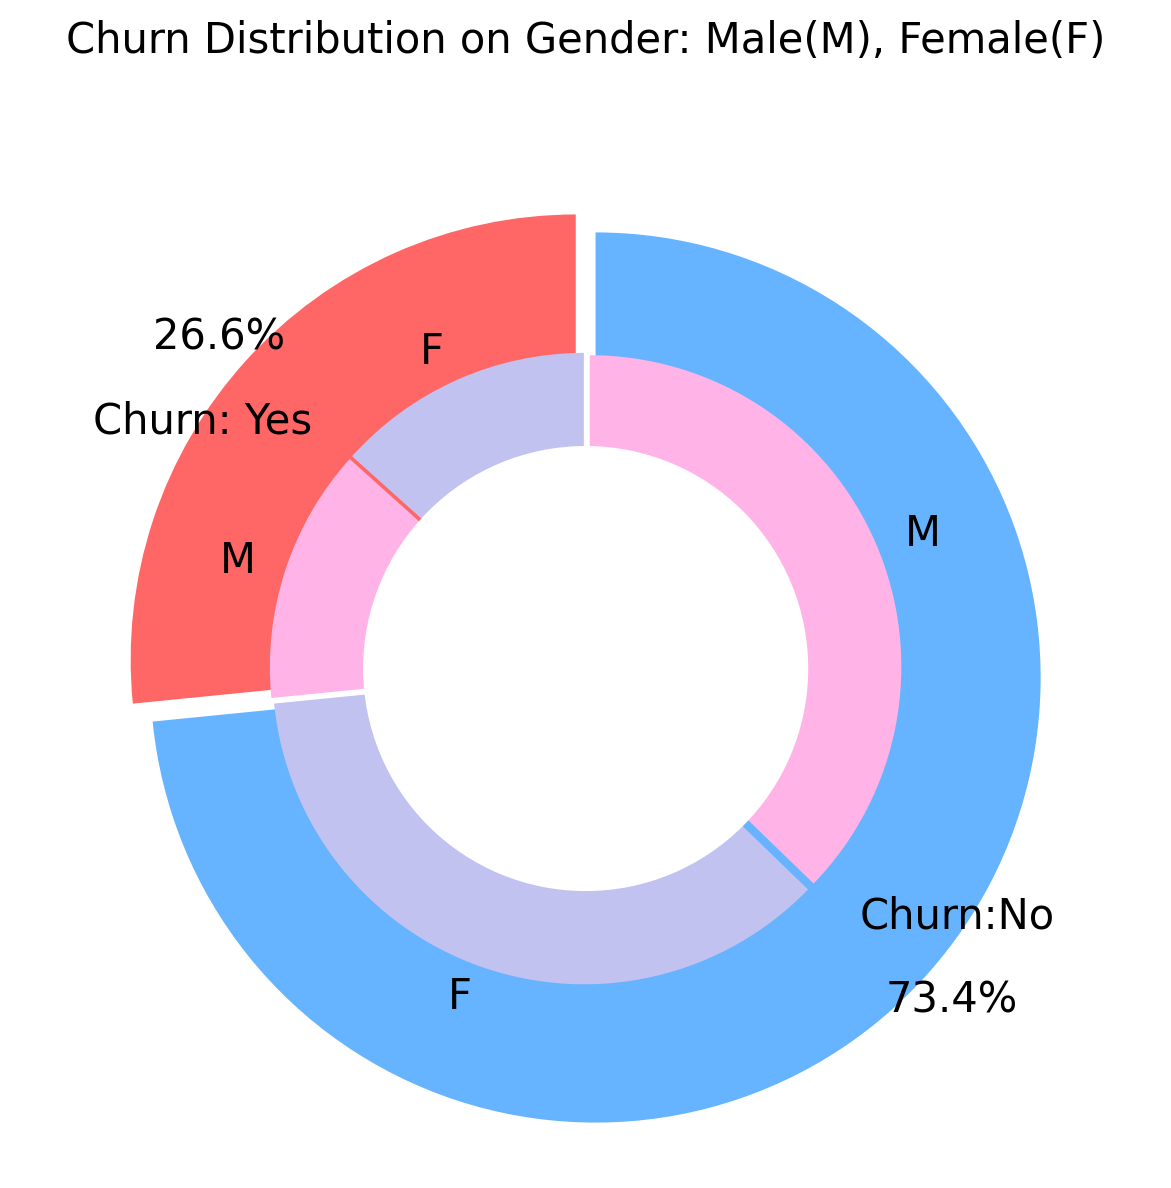

In [250]:
plt.figure(figsize=(6, 6))
labels =["Churn: Yes","Churn:No"]
values = [1869,5163]
labels_gender = ["F","M","F","M"]
sizes_gender = [939,930 , 2544,2619]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
explode = (0.3,0.3)
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Churn Distribution on Gender: Male(M), Female(F)', fontsize=15, y=1.1)

# show plot

plt.axis('equal')
plt.tight_layout()
plt.show()

**Conclusion**

- There is a difference in the percentage/calculation of customers who have changed service providers. Both men and women have a similar pattern when moving to other providers.

# **2.3 Create a histogram to see the distribution of Contract Type data used by Customer**

In [251]:
fig = px.histogram(df_final_provider, x="Churn", color="Type", barmode="group", title="<b>Distribution of Contract Type data used by Customer<b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

**Conclusion**

- Approximately **75%** customers with the `Month-to-Month` contract type choose to switch to another provider, in compared to **13%** customers with the `One Year` contract type, and **3%** with `Two Year` contract type

# **2.4 Piechart for distribution of Payment Methods**

In [252]:
labels = df_final_provider['PaymentMethod'].unique()
values = df_final_provider['PaymentMethod'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text="<b>Payment Method Distribution</b>")
fig.show()

# **2.5 Distribution histogram of Customer Payment Method against Churn**

In [253]:
fig = px.histogram(df_final_provider, x="Churn", color="PaymentMethod", title="<b>Customer Payment Method distribution against Churn</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

**Conclusion**

- The majority of customers who have switched to other providers use **Payment Method** with `Electronic Check` type
- Customers who use **Payment Method** type with `Credit-Card (automatic)` or `Bank transfer (automatic)`, and `Mailed check` have less tendency to switch to another provider

# **2.6 Barchart for Churn Distribution against Internet Service and Gender**

In [254]:
df_final_provider["InternetService"].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [255]:
df_final_provider[df_final_provider["gender"]=="Male"][["InternetService", "Churn"]].value_counts()

InternetService  Churn
DSL              0        993
Fiber optic      0        910
No               0        722
Fiber optic      1        633
DSL              1        240
No               1         57
dtype: int64

In [256]:
df_final_provider[df_final_provider["gender"]=="Female"][["InternetService", "Churn"]].value_counts()

InternetService  Churn
DSL              0        969
Fiber optic      0        889
No               0        691
Fiber optic      1        664
DSL              1        219
No               1         56
dtype: int64

In [257]:
fig = go.Figure()

fig.add_trace(go.Bar(
  x = [['Churn:0', 'Churn:0', 'Churn:1', 'Churn:1'],
       ["Female", "Male", "Female", "Male"]],
  y = [965, 992, 219, 240],
  name = 'DSL',
))

fig.add_trace(go.Bar(
  x = [['Churn:0', 'Churn:0', 'Churn:1', 'Churn:1'],
       ["Female", "Male", "Female", "Male"]],
  y = [889, 910, 664, 633],
  name = 'Fiber optic',
))

fig.add_trace(go.Bar(
  x = [['Churn:0', 'Churn:0', 'Churn:1', 'Churn:1'],
       ["Female", "Male", "Female", "Male"]],
  y = [690, 717, 56, 57],
  name = 'No Internet',
))

fig.update_layout(title_text="<b>Churn Distribution against Internet Service and Gender</b>")

fig.show()

**Conclusion**

- There are many customers who choose `InternetService` with the `Fiber optic` type and this also proves that customers who use `Fiber optic` have a **high churn rate**, this may be due to customer dissatisfaction with the service.
- Customers who use `InternetService` with `DSL` type have the largest number of customers, and have a **low churn rate** in compared to `Fiber optic` services.

# **2.7 Histogram for Churn Distribution against Dependents**

In [258]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(df_final_provider, x="Churn", color="Dependents", barmode="group", title="<b>Churn Distribution against Dependents</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

**Conclusion**

- Customers without dependants are more likely to have a high churn

# **2.8 Histogram for Churn Distribution against Partners**

In [259]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(df_final_provider, x="Churn", color="Partner", barmode="group", title="<b>Churn Distribution against Partners</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

**Conclusion**

- Customers who don't have a partner are more likely to have a high churn

# **2.9 Histogram for Churn Distribution against Senior Citizens**

In [260]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(df_final_provider, x="Churn", color="SeniorCitizen", title="<b>Churn Distribution against Senior Citizens</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

**Conclusion**

- The majority of senior citizens have a high churn

# **2.10 Histogram for Churn Distribution against Online Security**

In [261]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(df_final_provider, x="Churn", color="OnlineSecurity", barmode="group", title="<b>Churn Distribution against Online Security</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

**Conclusion**

- The majority of customers have a high churn due to the absence of Online Security

# **2.11 Histogram for Churn Distribution against Paperless Billing**

In [262]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(df_final_provider, x="Churn", color="PaperlessBilling",  title="<b>Churn Distribution against Paperless Billing</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

**Conclusion**

- Customers with Paperless Billing are more likely to switch to other providers (have a high churn rate)

# **2.12 Histogram for Churn Distribution against Tech Support**

In [263]:
fig = px.histogram(df_final_provider, x="Churn", color="TechSupport",barmode="group",  title="<b>Churn Distribution against Tech Support</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

**Conclusion**

- Customers without TechSupport are more likely to migrate to other providers.

# **2.13 Histogram for Churn Distribution against Online Backup**

In [264]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(df_final_provider, x="Churn", color="OnlineBackup", title="<b>Churn Distribution against Online Backup</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

**Conclusion**

- Customers without Online Backup are more likely to switch to another provider (has a high churn rate)

# **2.14 Histogram for Churn Distribution against Device Protection**

In [265]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(df_final_provider, x="Churn", color="DeviceProtection", title="<b>Churn Distribution against Device Protection</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

**Conclusion**

- Customers without Device Protection are more likely to switch to another provider (has a high churn rate)

# **2.15 Histogram for Churn Distribution against Streaming TV**

In [266]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(df_final_provider, x="Churn", color="StreamingTV", title="<b>Churn Distribution against Streaming TV</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

**Conclusion**

- Customers without Streaming TV are more likely to switch to other providers (have a high churn rate)

# **2.16 Histogram for Churn Distribution against Streaming Movies**

In [267]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(df_final_provider, x="Churn", color="StreamingMovies", title="<b>Churn Distribution against Streaming Movies</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

**Conclusion**

- Customers without Streaming Movies are more likely to switch to other providers (have a high churn rate)

# **2.17 Histogram for Churn Distribution against Multiple Lines**

In [268]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(df_final_provider, x="Churn", color="MultipleLines", title="<b>Churn Distribution against Multiple Lines</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

**Conclusion**

- Customers without Multiple Lines are more likely to switch to another provider (have a high churn rate)

# **2.18 Kdeplots for distribution of monthly charges at churn**

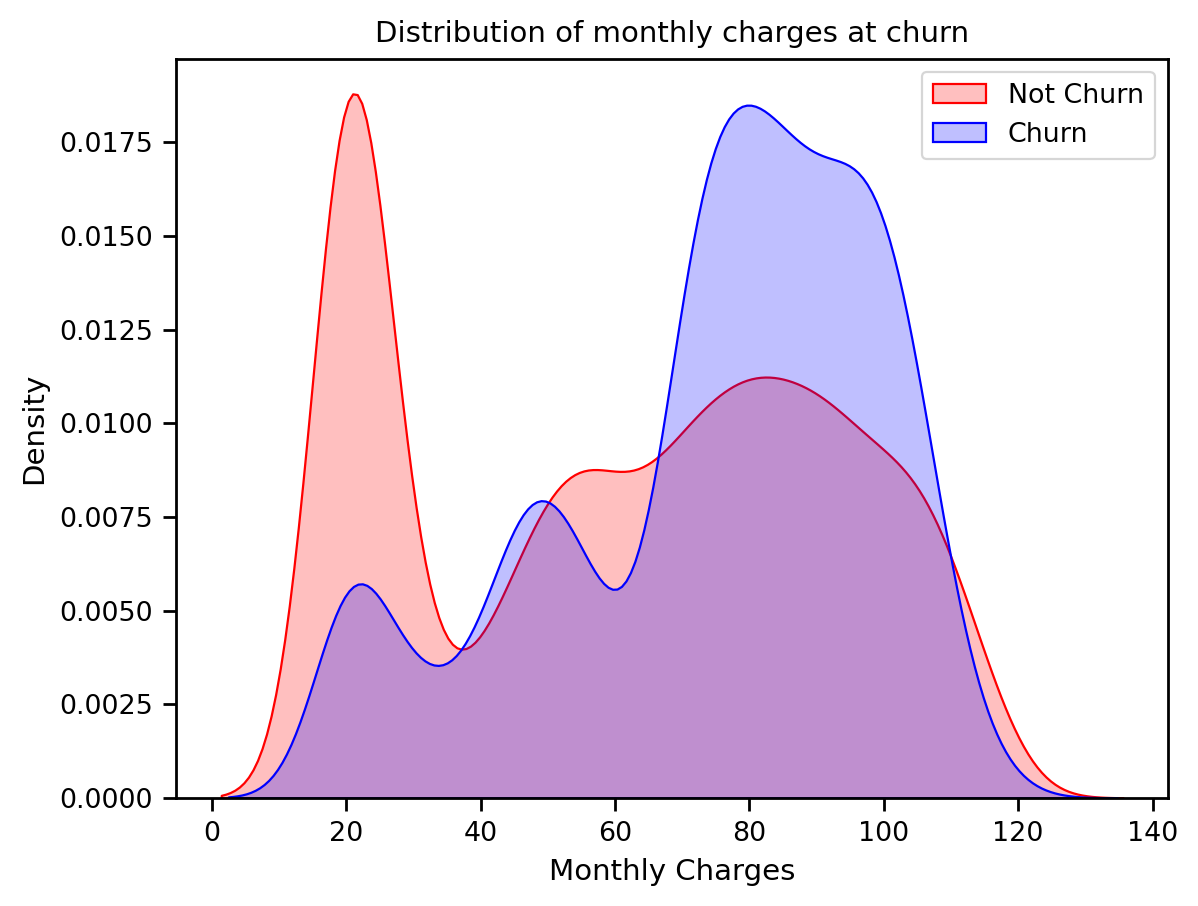

In [269]:
sns.set_context("paper",font_scale=1.1)
ax = sns.kdeplot(df_final_provider.MonthlyCharges[(df_final_provider["Churn"] == 0) ],
                color="Red", shade = True);
ax = sns.kdeplot(df_final_provider.MonthlyCharges[(df_final_provider["Churn"] == 1) ],
                ax =ax, color="Blue", shade= True);
ax.legend(["Not Churn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Monthly Charges');
ax.set_title('Distribution of monthly charges at churn');

**Conclusion**

- Customers with high Monthly Charges are more likely to switch providers


# **2.19 Kdeplot for distribution of total charges at churn**

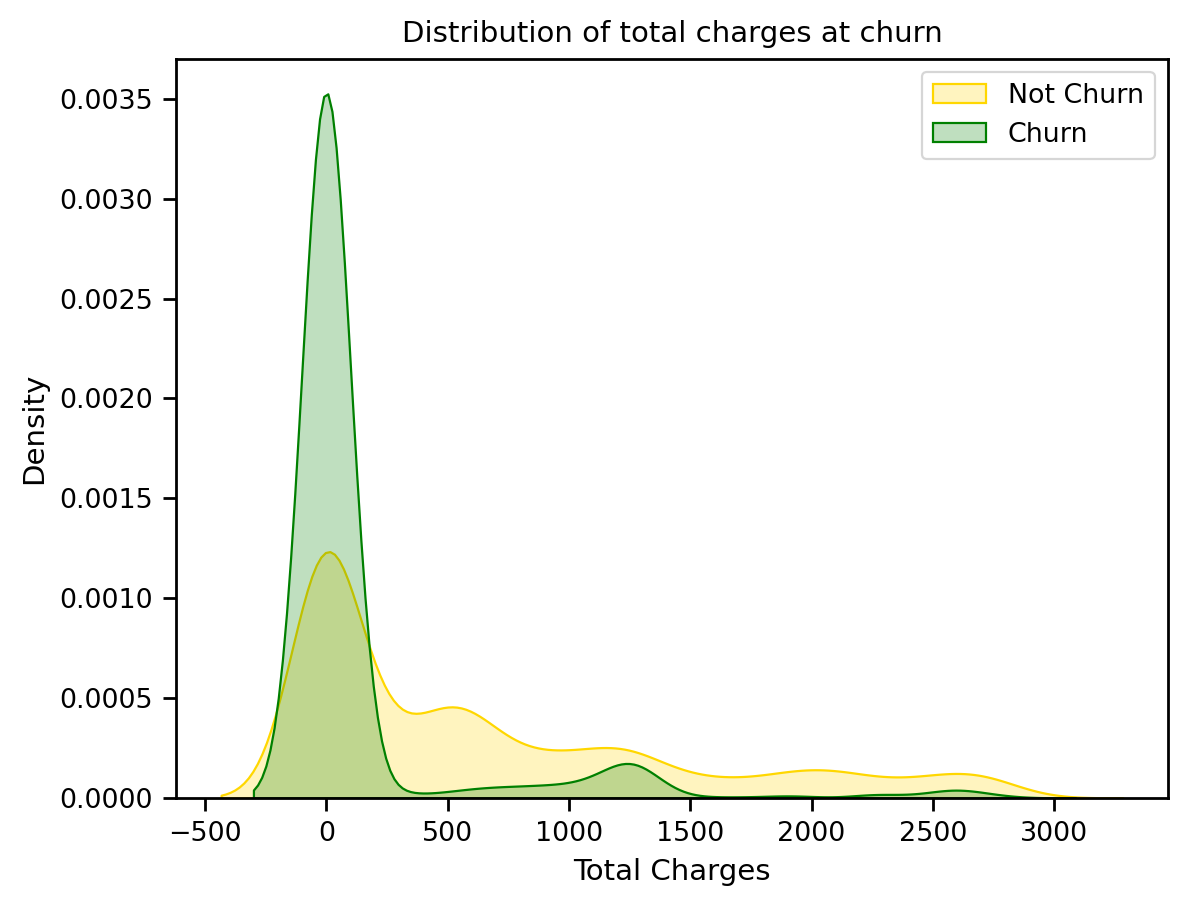

In [270]:
ax = sns.kdeplot(df_final_provider.TotalCharges[(df_final_provider["Churn"] == 0) ],
                color="Gold", shade = True);
ax = sns.kdeplot(df_final_provider.TotalCharges[(df_final_provider["Churn"] == 1) ],
                ax =ax, color="Green", shade= True);
ax.legend(["Not Churn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Total Charges');
ax.set_title('Distribution of total charges at churn');

**Conclusion**

- Customers with lower Total Charges are more likely to switch providers

**Check correlation between columns using heatmap**

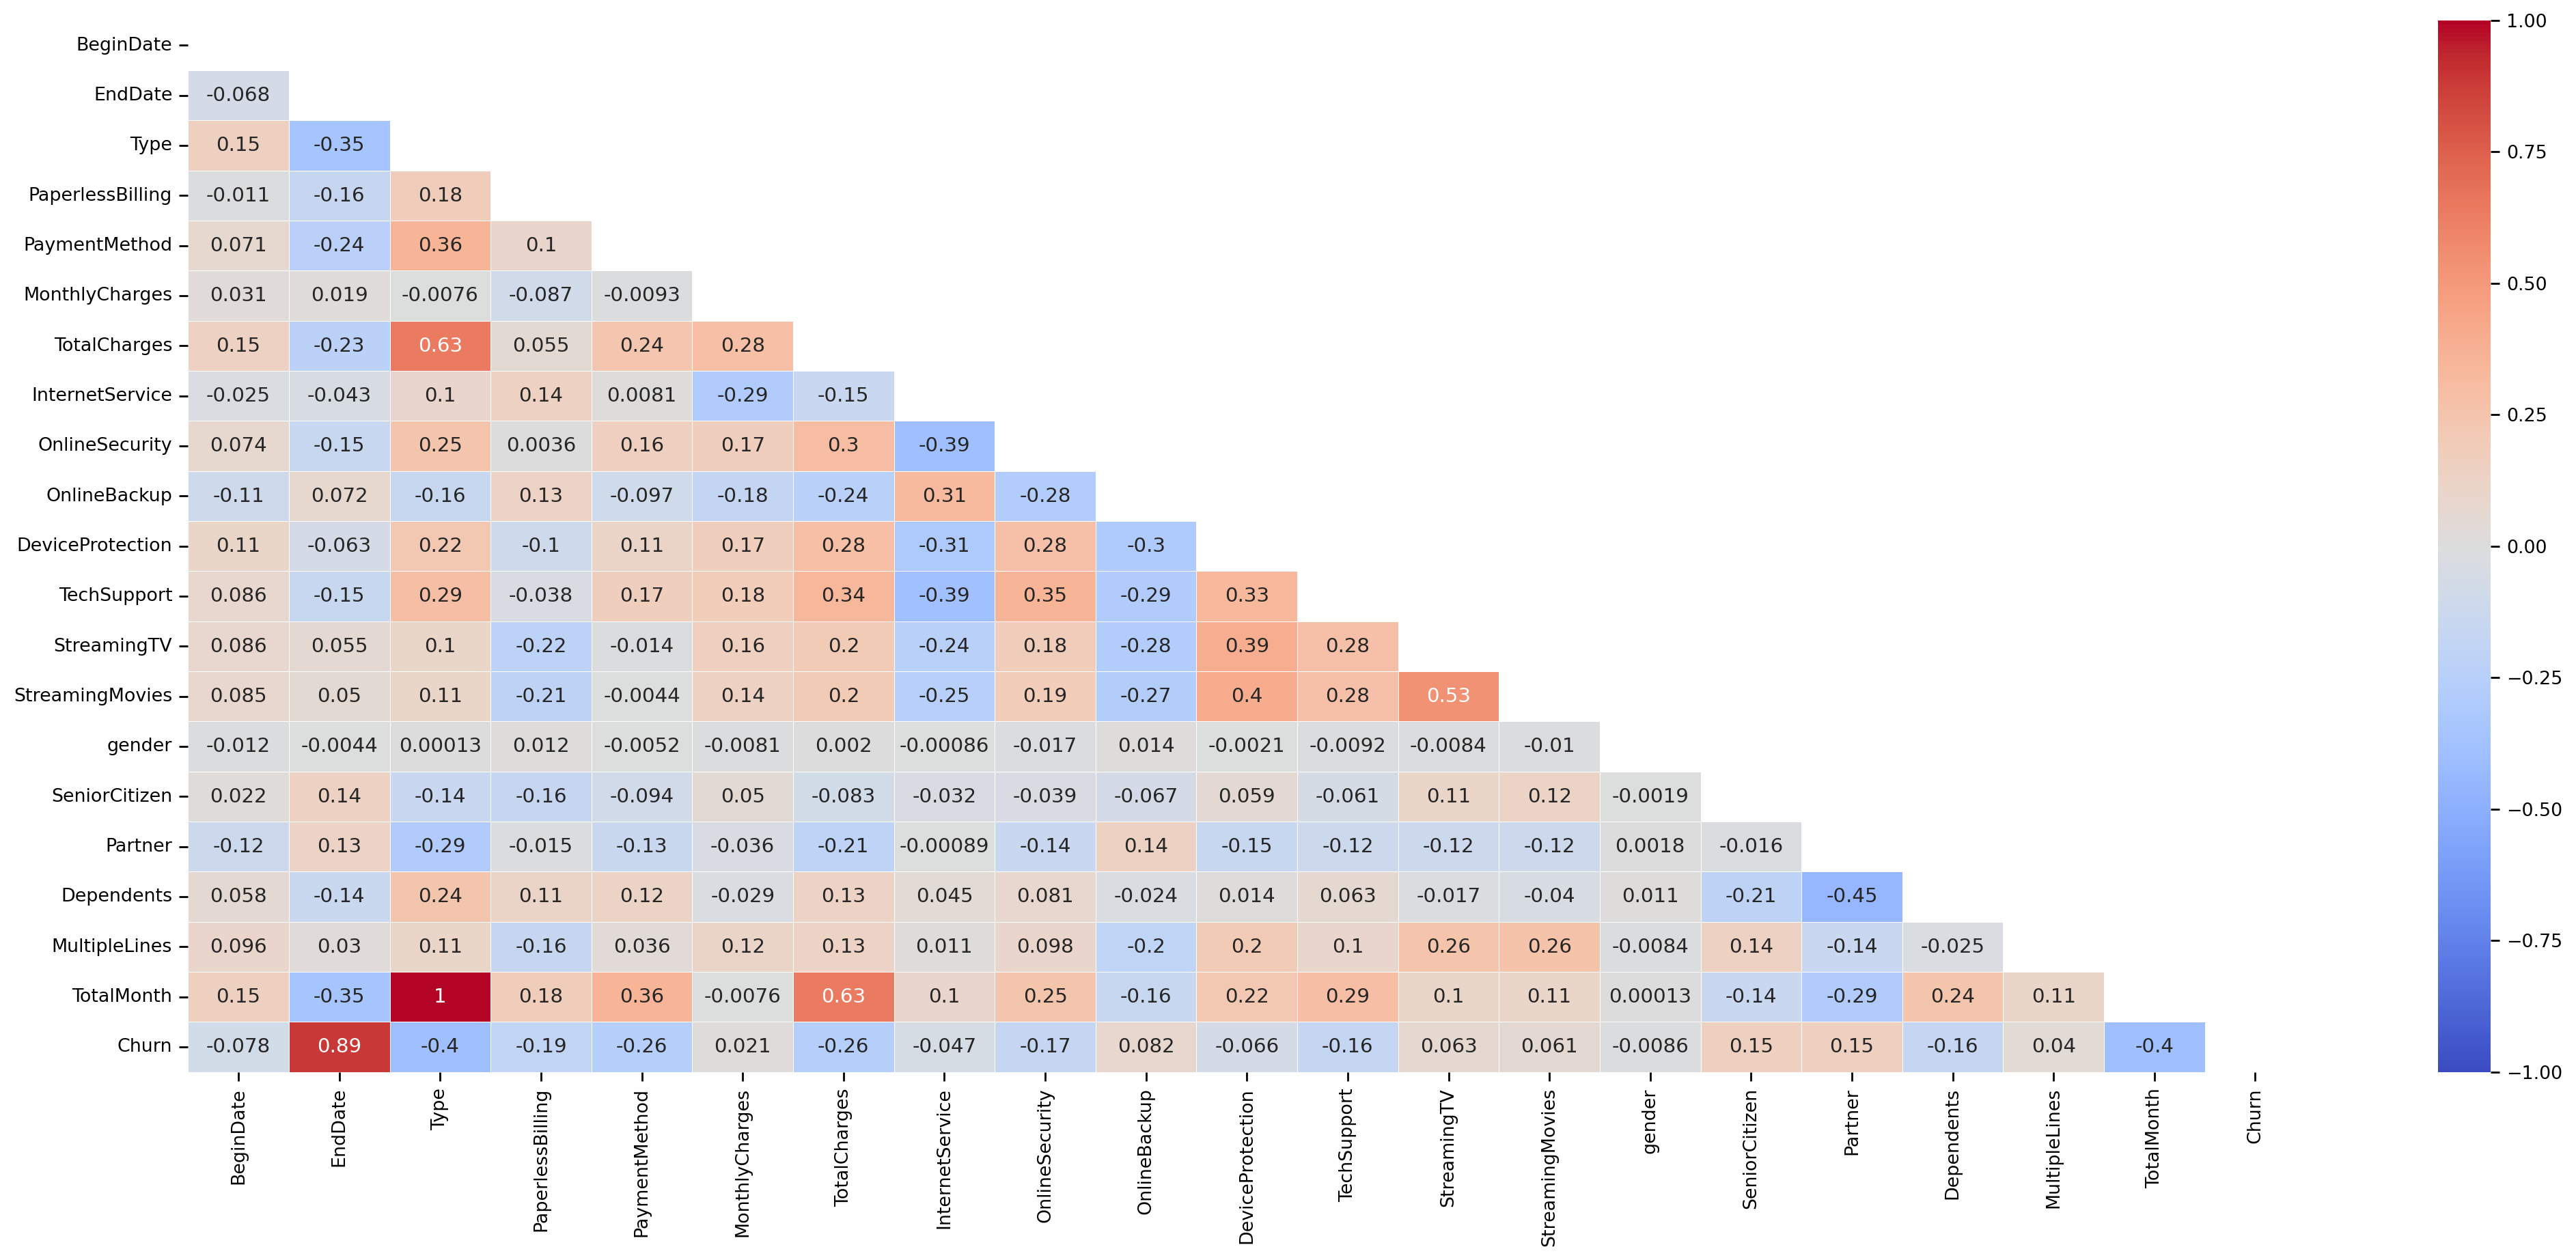

In [271]:
plt.figure(figsize=(25, 10))

corr = df_final_provider.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

# **3. Data Preprocessing**

# **3.1 Split the dataset into train set and test set**

In [272]:
# Create new kcolumn BeginYear and BeginMonth for BeginDate column
df_final_provider['BeginYear'] = df_final_provider['BeginDate'].dt.year
df_final_provider['BeginMonth'] = df_final_provider['BeginDate'].dt.month

# Create new column EndYear and EndMonth for EndDate column
df_final_provider['EndYear'] = df_final_provider['EndDate'].dt.year
df_final_provider['EndMonth'] = df_final_provider['EndDate'].dt.month

In [273]:
# Fill 'No' (NULL) value with 0 value, and convert the datatype to int
df_final_provider['EndYear'] = df_final_provider['EndYear'].fillna(0).astype(int)
df_final_provider['EndMonth'] = df_final_provider['EndMonth'].fillna(0).astype(int)

In [274]:
# Fill 'No' (NULL) value with mean
df_final_provider['TotalMonth'] = df_final_provider['TotalMonth'].fillna(df_final_provider['TotalMonth'].mean()).apply(np.ceil)

In [275]:
df_final_provider['TotalMonth'].astype(int)

0       19
1       12
2       19
3       12
4       19
        ..
7038    12
7039    12
7040    19
7041    19
7042    24
Name: TotalMonth, Length: 7043, dtype: int64

In [276]:
df_final_provider.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           1869 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   InternetService   7043 non-null   object        
 8   OnlineSecurity    7043 non-null   object        
 9   OnlineBackup      7043 non-null   object        
 10  DeviceProtection  7043 non-null   object        
 11  TechSupport       7043 non-null   object        
 12  StreamingTV       7043 non-null   object        
 13  StreamingMovies   7043 non-null   object        
 14  gender            7043 n

In [277]:
#Drop unused columns
drop_cols = ['BeginDate', 'EndDate', 'EndYear', 'EndMonth']
df_final_provider.drop(drop_cols, axis=1, inplace=True)

In [278]:
numerical_cols = ['TotalMonth', 'MonthlyCharges', 'TotalCharges']
df_final_provider[numerical_cols].describe()

,TotalMonth,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,18.739316,64.761692,514.260912
std,4.024799,30.090047,756.382869
min,12.000000,18.250000,0.000000
25%,19.000000,35.500000,0.000000
50%,19.000000,70.350000,0.000000
75%,19.000000,89.850000,843.300000
max,24.000000,118.750000,2850.000000


In [279]:
def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

In [280]:
df_final_provider = df_final_provider.apply(lambda x: object_to_int(x))
df_final_provider.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,TotalMonth,Churn,BeginYear,BeginMonth
0,0,1,2,29.85,0.0,0,0,1,0,0,...,0,0,0,1,0,0,19.0,0,2020,1
1,1,0,3,56.95,683.4,0,1,0,1,0,...,0,1,0,0,0,0,12.0,0,2017,4
2,0,1,3,53.85,0.0,0,1,1,0,0,...,0,1,0,0,0,0,19.0,1,2019,10
3,1,0,0,42.30,507.6,0,1,0,1,1,...,0,1,0,0,0,0,12.0,0,2016,5
4,0,1,2,70.70,0.0,1,0,0,0,0,...,0,0,0,0,0,0,19.0,1,2019,9


In [281]:
plt.figure(figsize=(14,7))
df_final_provider.corr()['Churn'].sort_values(ascending = False)

Churn               1.000000
BeginYear           0.291621
MonthlyCharges      0.193356
PaperlessBilling    0.191825
BeginMonth          0.181417
SeniorCitizen       0.150889
PaymentMethod       0.107062
StreamingTV         0.063228
StreamingMovies     0.061382
MultipleLines       0.040102
gender             -0.008612
TotalMonth         -0.034741
InternetService    -0.047291
DeviceProtection   -0.066160
OnlineBackup       -0.082255
Partner            -0.150448
Dependents         -0.164221
TechSupport        -0.164674
OnlineSecurity     -0.171226
TotalCharges       -0.294124
Type               -0.396713
Name: Churn, dtype: float64

<Figure size 1400x700 with 0 Axes>

In [282]:
X = df_final_provider.drop(columns = ['Churn'])
y = df_final_provider['Churn'].values

In [283]:
X

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,TotalMonth,BeginYear,BeginMonth
0,0,1,2,29.85,0.0,0,0,1,0,0,0,0,0,0,1,0,0,19.0,2020,1
1,1,0,3,56.95,683.4,0,1,0,1,0,0,0,1,0,0,0,0,12.0,2017,4
2,0,1,3,53.85,0.0,0,1,1,0,0,0,0,1,0,0,0,0,19.0,2019,10
3,1,0,0,42.30,507.6,0,1,0,1,1,0,0,1,0,0,0,0,12.0,2016,5
4,0,1,2,70.70,0.0,1,0,0,0,0,0,0,0,0,0,0,0,19.0,2019,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,1,3,84.80,1017.6,0,1,0,1,1,1,1,1,0,1,1,1,12.0,2018,2
7039,1,1,1,103.20,1238.4,1,0,1,1,0,1,1,0,0,1,1,1,12.0,2014,2
7040,0,1,2,29.60,0.0,0,1,0,0,0,0,0,0,0,1,1,0,19.0,2019,3
7041,0,1,3,74.40,0.0,1,0,0,0,0,0,0,1,1,1,0,1,19.0,2019,7


In [284]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 40, stratify=y)

In [285]:
def distplot(feature, frame, color='r'):
    plt.figure(figsize=(8,3))
    plt.title("Distribution for {}".format(feature))
    ax = sns.distplot(frame[feature], color= color)

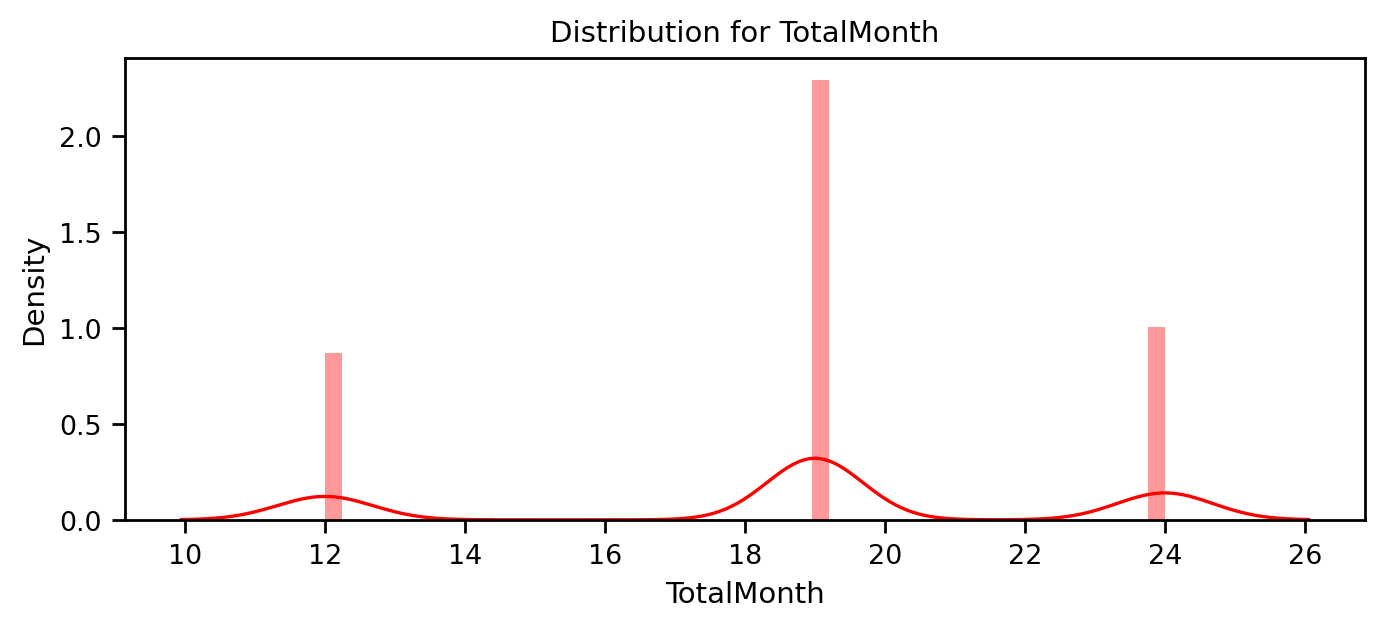

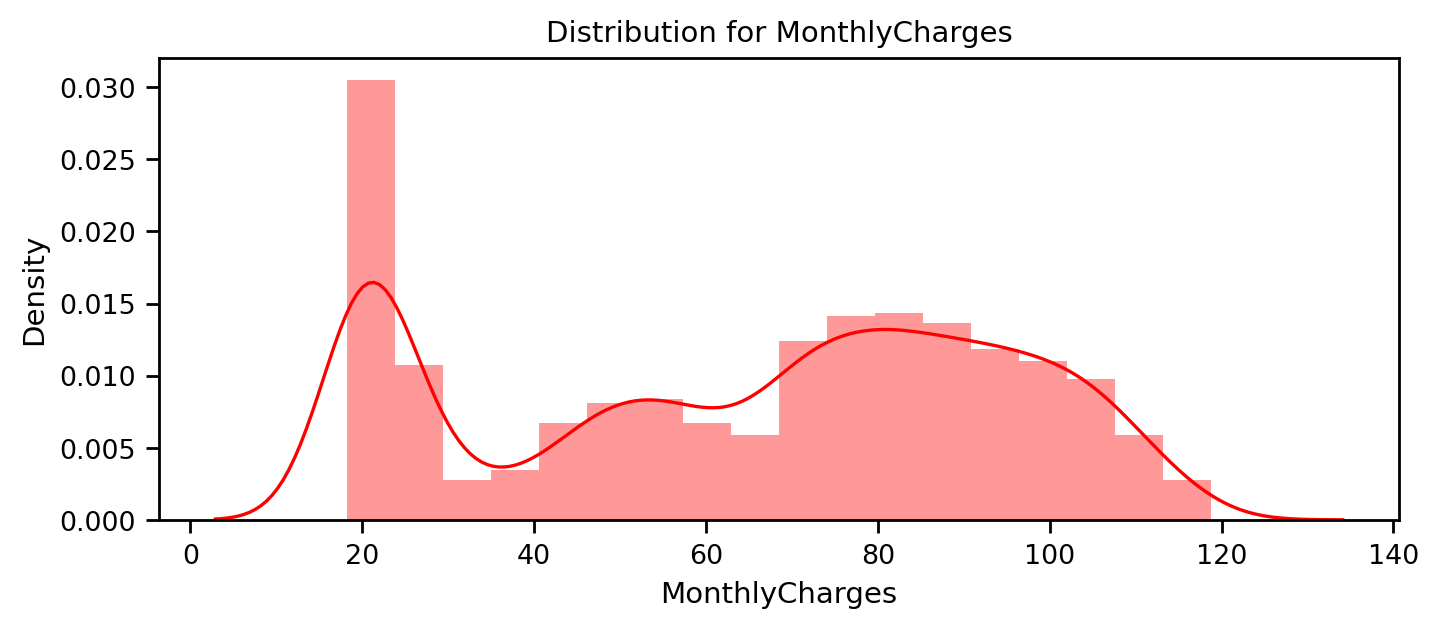

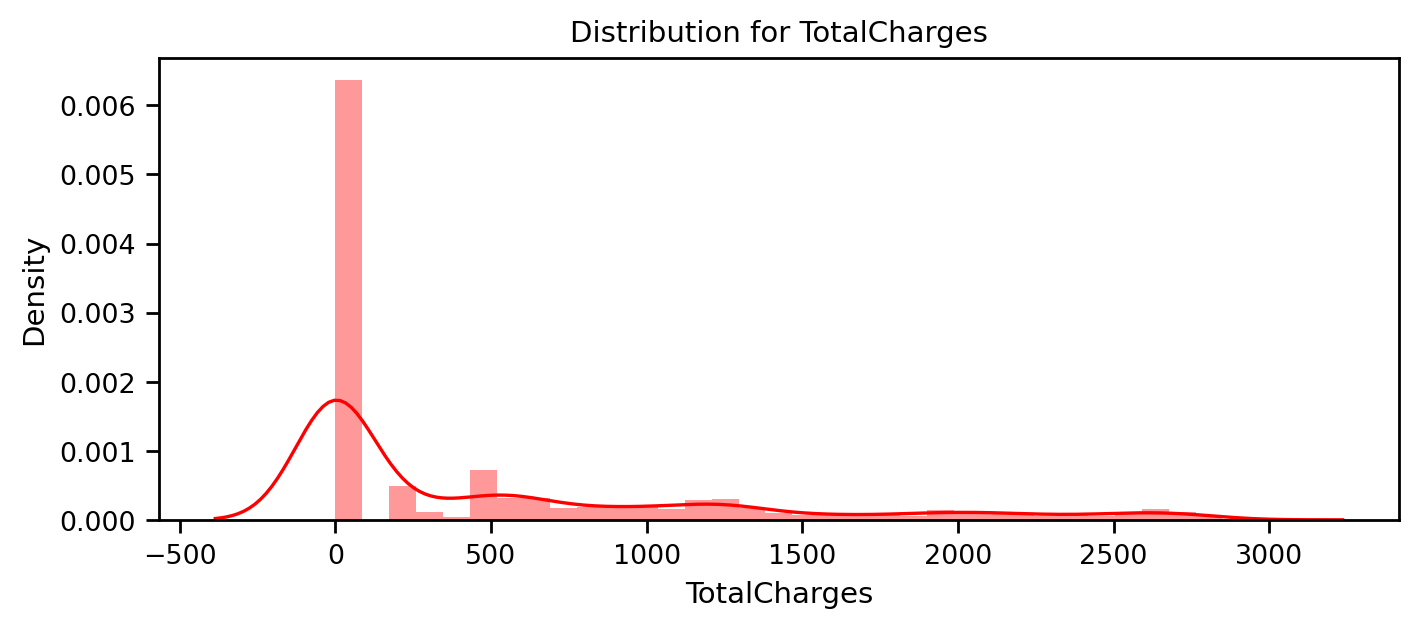

In [286]:
num_cols = ["TotalMonth", 'MonthlyCharges', 'TotalCharges']
for feat in num_cols: distplot(feat, df_final_provider)

**Conclusion**

because the numeric features are distributed over a different range of values, in this case we will use the scalar standard to scale down so they will adjusted to the same range.

# **3.2 Standardize numeric attributes**

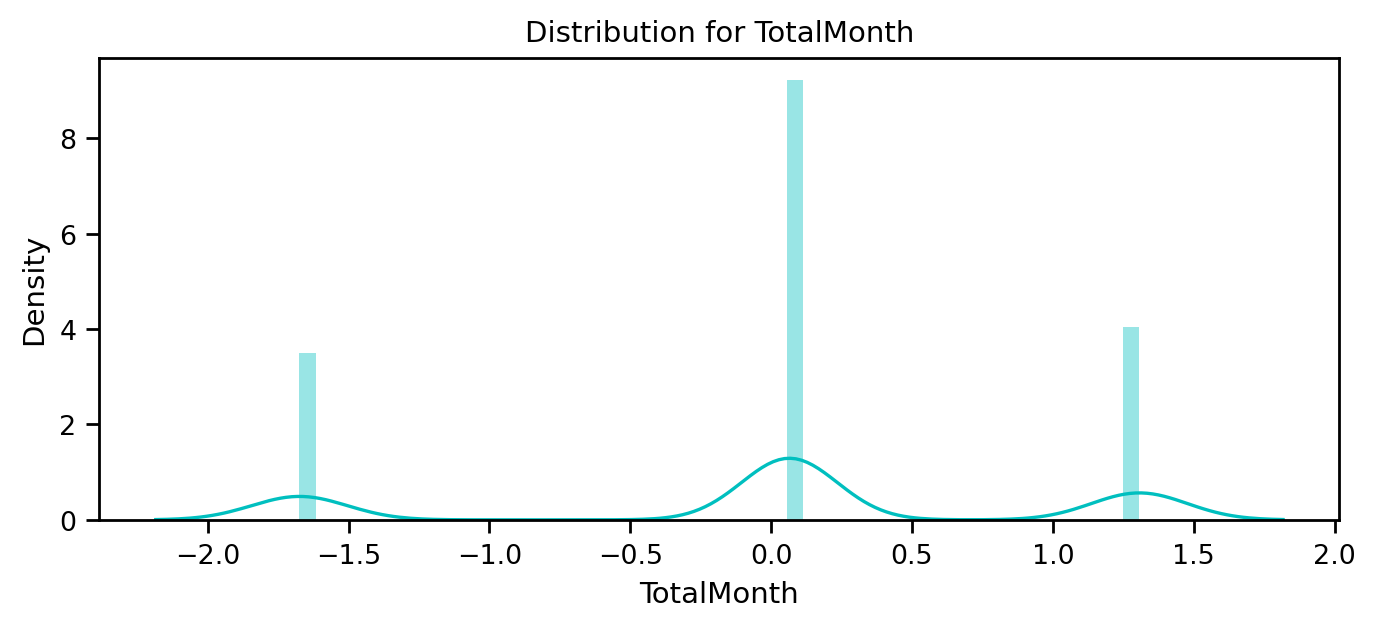

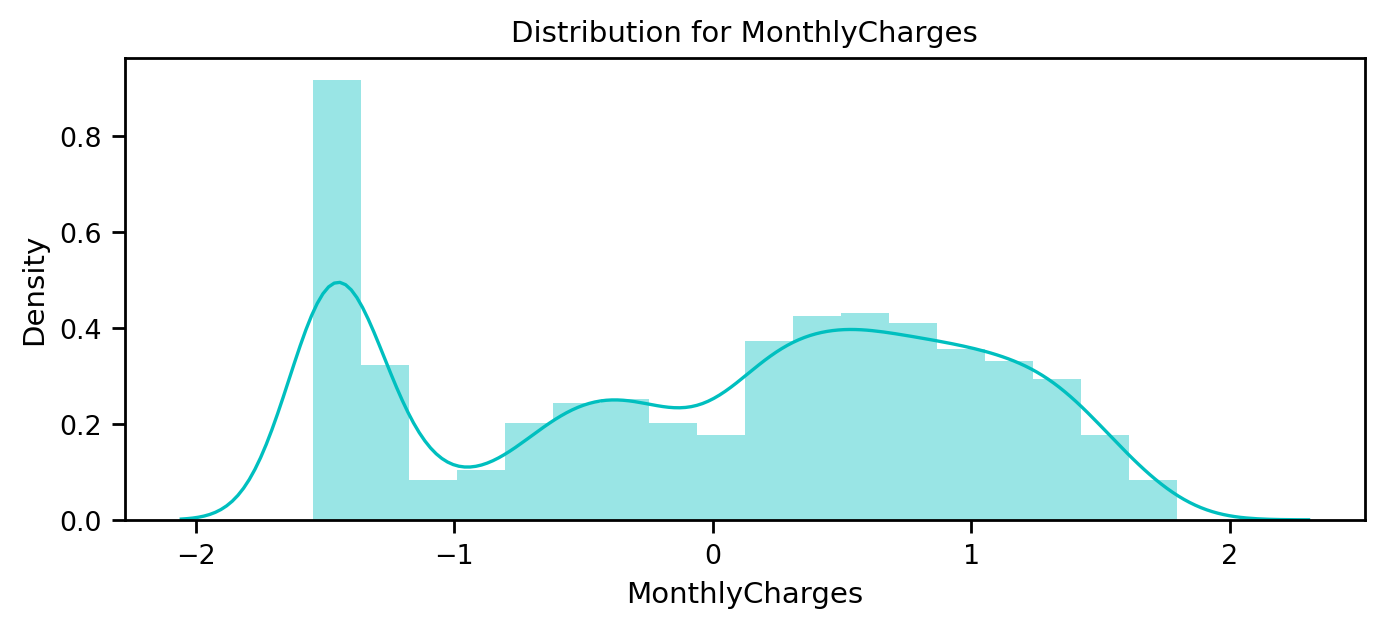

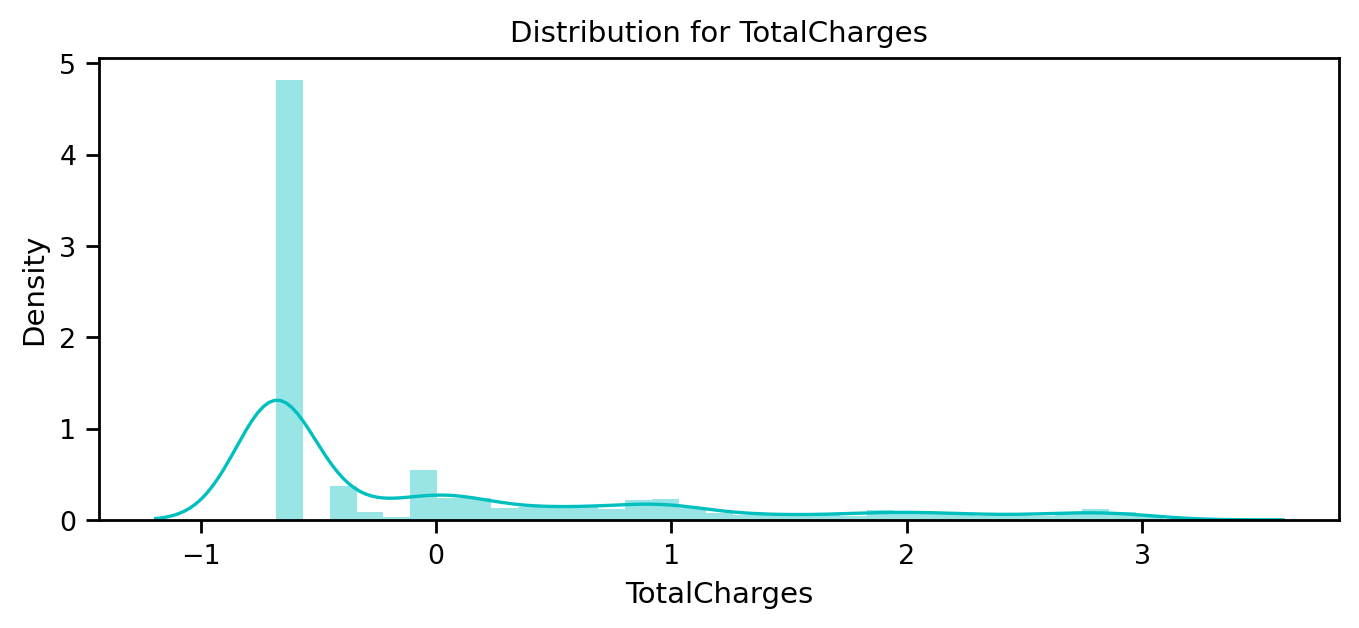

In [287]:
df_std = pd.DataFrame(StandardScaler().fit_transform(df_final_provider[num_cols].astype('float64')),
                       columns=num_cols)
for feat in numerical_cols: distplot(feat, df_std, color='c')

In [288]:
# Split the column into 3 categories, one for standardization, one for label encoding, and one for OHE
cat_cols_ohe =['PaymentMethod', 'Type', 'InternetService'] # column that require to OHE
cat_cols_le = list(set(X_train.columns)- set(num_cols) - set(cat_cols_ohe)) # column that requires label encoding

In [289]:
scaler= StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# **4. Machine Learning**

# **4.1 KNN**

In [290]:
knn_model = KNeighborsClassifier(n_neighbors = 11)
knn_model.fit(X_train,y_train)
predicted_y = knn_model.predict(X_test)
accuracy_knn = knn_model.score(X_test,y_test)
print("KNN accuracy:",accuracy_knn)

KNN accuracy: 0.7808802650260294


In [291]:
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1552
           1       0.58      0.61      0.60       561

    accuracy                           0.78      2113
   macro avg       0.72      0.73      0.72      2113
weighted avg       0.78      0.78      0.78      2113



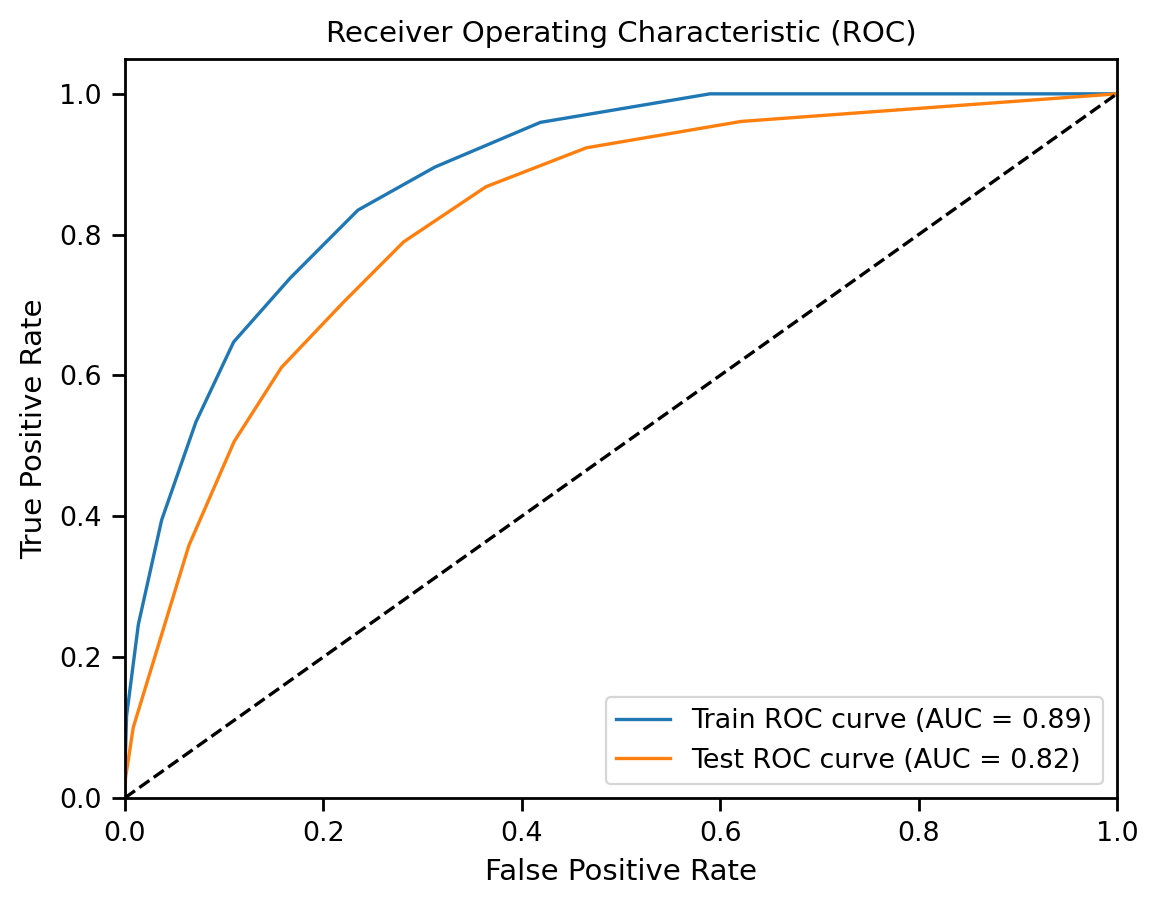

In [292]:
# Train the classifier/model and obtain predicted probabilities
knn_model.fit(X_train, y_train)
y_train_pred_prob = knn_model.predict_proba(X_train)[:, 1]
y_test_pred_prob = knn_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC scores
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

# Calculate False Positive Rate (fpr), True Positive Rate (tpr), and corresponding thresholds
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)

# Plot ROC curves
plt.plot(fpr_train, tpr_train, label='Train ROC curve (AUC = %0.2f)' % train_roc_auc)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (AUC = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line (diagonal)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Conclusion**

**F1-Score** accuracy of **KNN** at **0.78**

Accuracy of **ROC AUC** on the test set **KNN** is: **0.82**

The result is below the expected F1 target score, which is **0.85**.

# **4.2 SVC**

In [293]:
svc_model = SVC(random_state = 1)
svc_model.fit(X_train,y_train)
predict_y = svc_model.predict(X_test)
accuracy_svc = svc_model.score(X_test,y_test)
print("SVM accuracy is :",accuracy_svc)

SVM accuracy is : 0.73450070989115


In [294]:
print(classification_report(y_test, predict_y))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1552
           1       0.00      0.00      0.00       561

    accuracy                           0.73      2113
   macro avg       0.37      0.50      0.42      2113
weighted avg       0.54      0.73      0.62      2113



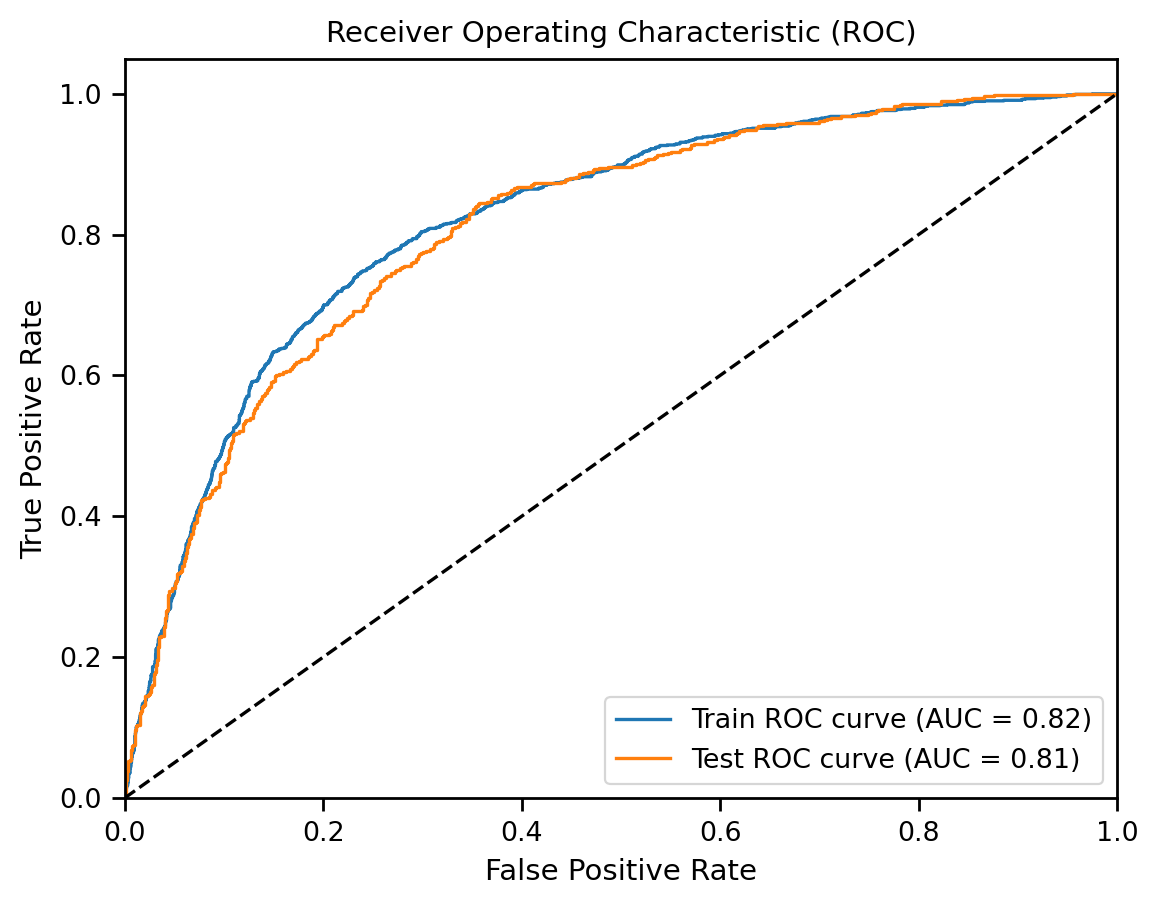

In [295]:
# Train the SVC model and obtain decision values
svc_model.fit(X_train, y_train)
decision_train = svc_model.decision_function(X_train)
decision_test = svc_model.decision_function(X_test)

# Convert decision values to predicted probabilities
y_train_pred_prob = 1 / (1 + np.exp(-decision_train))
y_test_pred_prob = 1 / (1 + np.exp(-decision_test))

# Calculate ROC AUC scores
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

# Calculate False Positive Rate (fpr), True Positive Rate (tpr), and corresponding thresholds
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)

# Plot ROC curves
plt.plot(fpr_train, tpr_train, label='Train ROC curve (AUC = %0.2f)' % train_roc_auc)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (AUC = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line (diagonal)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Conclusion**

**F1-Score** accuracy of **SVC** at **0.73**

Accuracy of **ROC AUC** on the test set **SVC** is: **0.81**

The result is below the expected F1 target score, which is **0.85**.

# **4.3 Random Forest**

In [296]:
model_rf = RandomForestClassifier(n_estimators=500 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print (metrics.accuracy_score(y_test, prediction_test))

0.8017037387600567


In [297]:
print(classification_report(y_test, prediction_test))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1552
           1       0.66      0.53      0.59       561

    accuracy                           0.80      2113
   macro avg       0.75      0.72      0.73      2113
weighted avg       0.79      0.80      0.79      2113



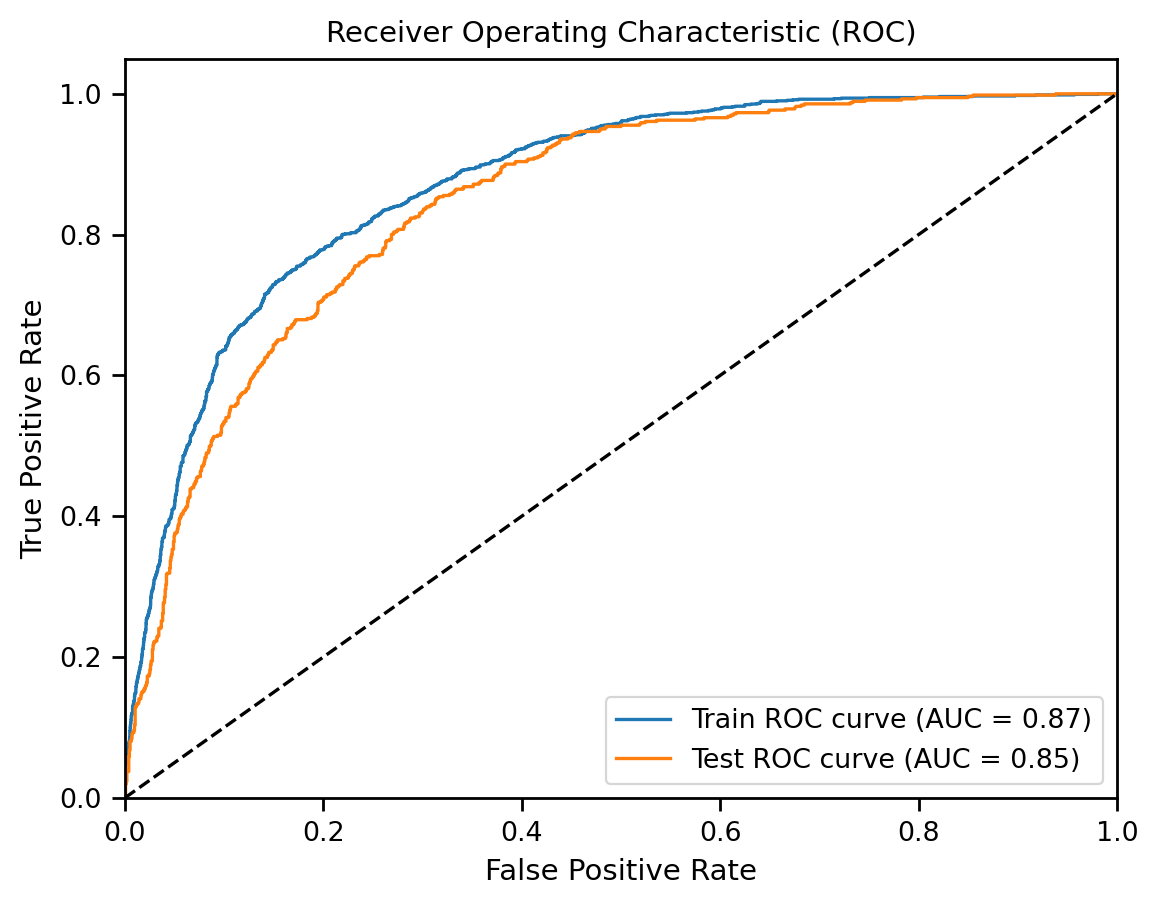

In [298]:
# Train the classifier/model and obtain predicted probabilities
model_rf.fit(X_train, y_train)
y_train_pred_prob = model_rf.predict_proba(X_train)[:, 1]
y_test_pred_prob = model_rf.predict_proba(X_test)[:, 1]

# Calculate ROC AUC scores
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

# Calculate False Positive Rate (fpr), True Positive Rate (tpr), and corresponding thresholds
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)

# Plot ROC curves
plt.plot(fpr_train, tpr_train, label='Train ROC curve (AUC = %0.2f)' % train_roc_auc)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (AUC = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line (diagonal)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Conclusion**

**F1-Score** accuracy of **Random Forest** at **0.80**

Accuracy of **ROC AUC** on the test set **Random Forest** is: **0.85**

The result has already reached the expected F1 target score, which is **0.85**.

# **4.4 Logistic Regression**

In [299]:
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)
accuracy_lr = lr_model.score(X_test,y_test)
print("Logistic Regression accuracy is :",accuracy_lr)

Logistic Regression accuracy is : 0.7785139611926172


In [300]:
lr_pred= lr_model.predict(X_test)
report = classification_report(y_test,lr_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1552
           1       0.59      0.52      0.56       561

    accuracy                           0.78      2113
   macro avg       0.71      0.70      0.70      2113
weighted avg       0.77      0.78      0.77      2113



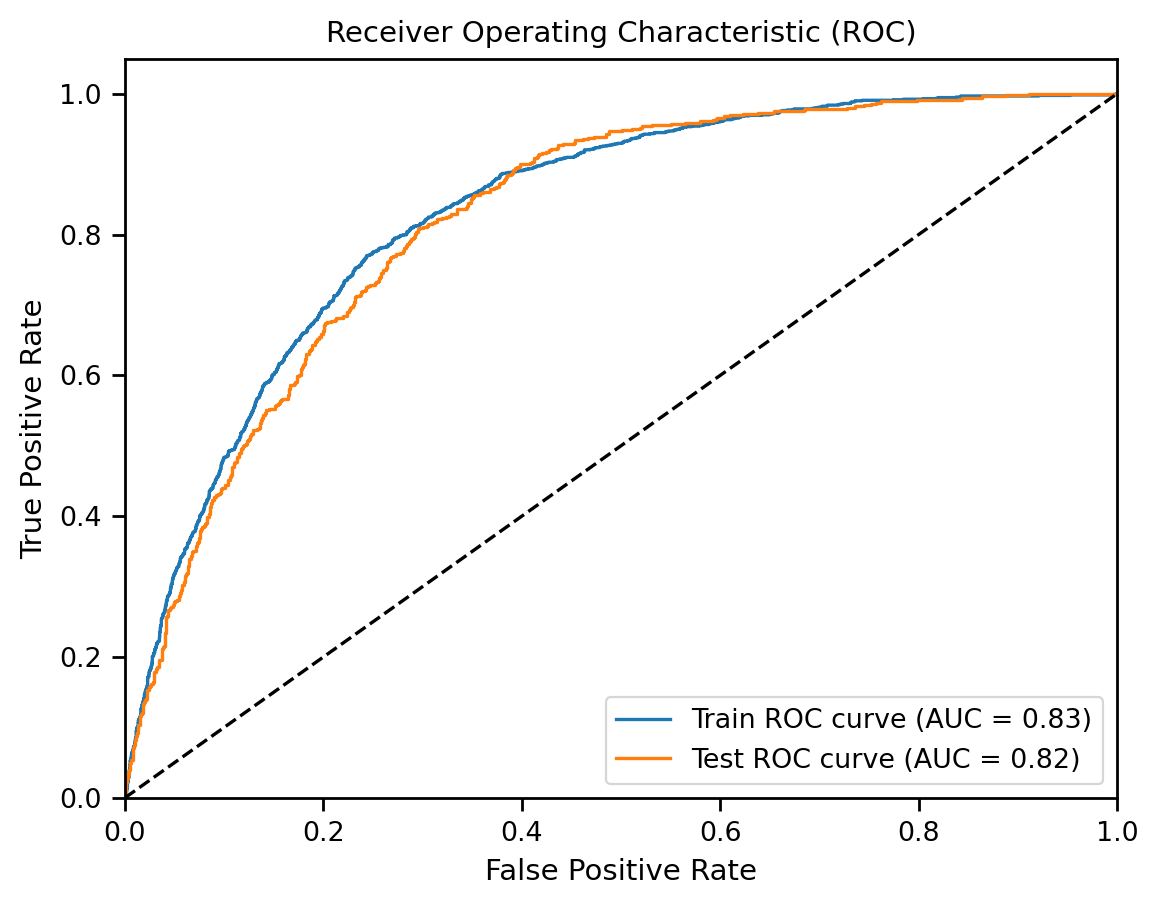

In [301]:
# Train the classifier/model and obtain predicted probabilities
lr_model.fit(X_train, y_train)
y_train_pred_prob = lr_model.predict_proba(X_train)[:, 1]
y_test_pred_prob = lr_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC scores
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

# Calculate False Positive Rate (fpr), True Positive Rate (tpr), and corresponding thresholds
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)

# Plot ROC curves
plt.plot(fpr_train, tpr_train, label='Train ROC curve (AUC = %0.2f)' % train_roc_auc)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (AUC = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line (diagonal)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Conclusion**

**F1-Score** accuracy of **Logistic Regression** at **0.78**

Accuracy of **ROC AUC** on the test set **Logistic Regression** is: **0.82**

The result is below the expected F1 target score, which is **0.85**.

# **4.5 Decision Tree Classifier**

In [302]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,y_train)
predictdt_y = dt_model.predict(X_test)
accuracy_dt = dt_model.score(X_test,y_test)
print("Decision Tree accuracy is :",accuracy_dt)

Decision Tree accuracy is : 0.7349739706578324


In [303]:
print(classification_report(y_test, predictdt_y))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1552
           1       0.50      0.54      0.52       561

    accuracy                           0.73      2113
   macro avg       0.67      0.67      0.67      2113
weighted avg       0.74      0.73      0.74      2113



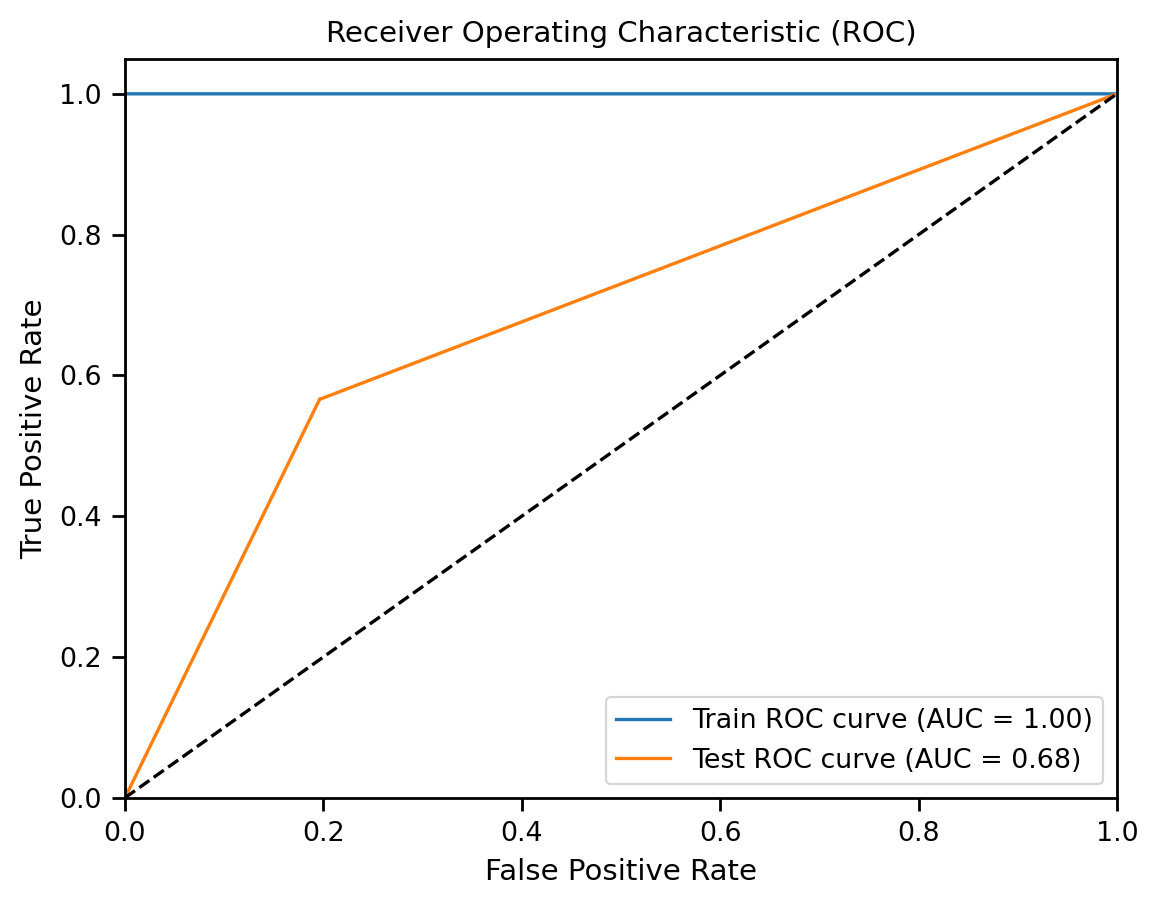

In [304]:
# Train the classifier/model and obtain predicted probabilities
dt_model.fit(X_train, y_train)
y_train_pred_prob = dt_model.predict_proba(X_train)[:, 1]
y_test_pred_prob = dt_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC scores
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

# Calculate False Positive Rate (fpr), True Positive Rate (tpr), and corresponding thresholds
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)

# Plot ROC curves
plt.plot(fpr_train, tpr_train, label='Train ROC curve (AUC = %0.2f)' % train_roc_auc)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (AUC = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line (diagonal)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Conclusion**

**F1-Score** accuracy of **Decision Tree Classifier** at **0.74**

Accuracy of **ROC AUC** on the test set **Decision Tree Classifier** is: **0.69**

The result is far below the expected F1 target score, which is **0.85**.

# **4.6 AdaBoost Classifier**

In [305]:
a_model = AdaBoostClassifier()
a_model.fit(X_train,y_train)
a_preds = a_model.predict(X_test)
print("AdaBoost Classifier accuracy")
metrics.accuracy_score(y_test, a_preds)

AdaBoost Classifier accuracy


0.79649787032655

In [306]:
print(classification_report(y_test, a_preds))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1552
           1       0.63      0.57      0.60       561

    accuracy                           0.80      2113
   macro avg       0.74      0.72      0.73      2113
weighted avg       0.79      0.80      0.79      2113



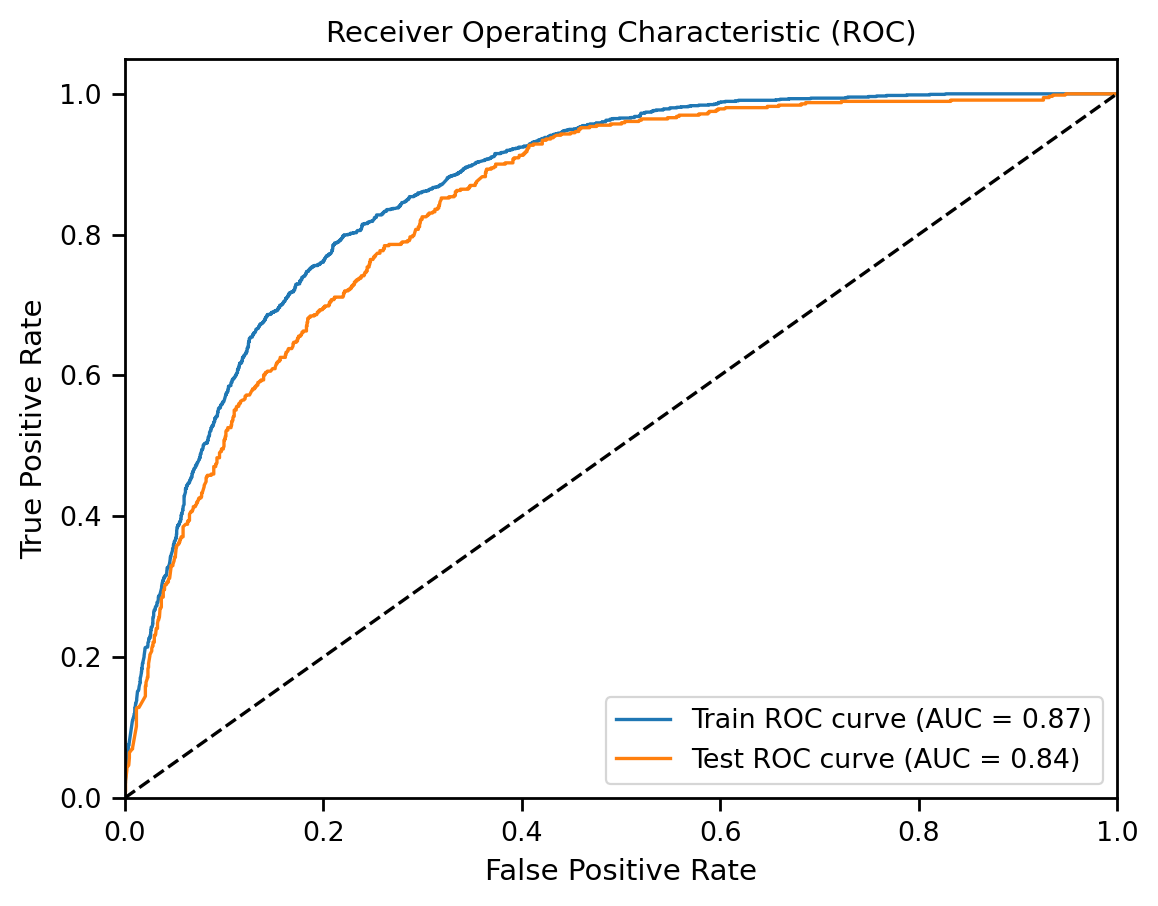

In [307]:
# Train the classifier/model and obtain predicted probabilities
a_model.fit(X_train, y_train)
y_train_pred_prob = a_model.predict_proba(X_train)[:, 1]
y_test_pred_prob = a_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC scores
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

# Calculate False Positive Rate (fpr), True Positive Rate (tpr), and corresponding thresholds
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)

# Plot ROC curves
plt.plot(fpr_train, tpr_train, label='Train ROC curve (AUC = %0.2f)' % train_roc_auc)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (AUC = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line (diagonal)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Conclusion**

**F1-Score** accuracy of **AdaBoost Classifier** at **0.80**

Accuracy of **ROC AUC** on the test set **AdaBoost Classifier** is: **0.84**

The result is below the expected F1 target score, which is **0.85**.

# **4.7 Gradient Boosting Classifier**

In [308]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
print("Gradient Boosting Classifier", accuracy_score(y_test, gb_pred))

Gradient Boosting Classifier 0.7946048272598202


In [309]:
print(classification_report(y_test, gb_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1552
           1       0.62      0.57      0.59       561

    accuracy                           0.79      2113
   macro avg       0.74      0.72      0.73      2113
weighted avg       0.79      0.79      0.79      2113



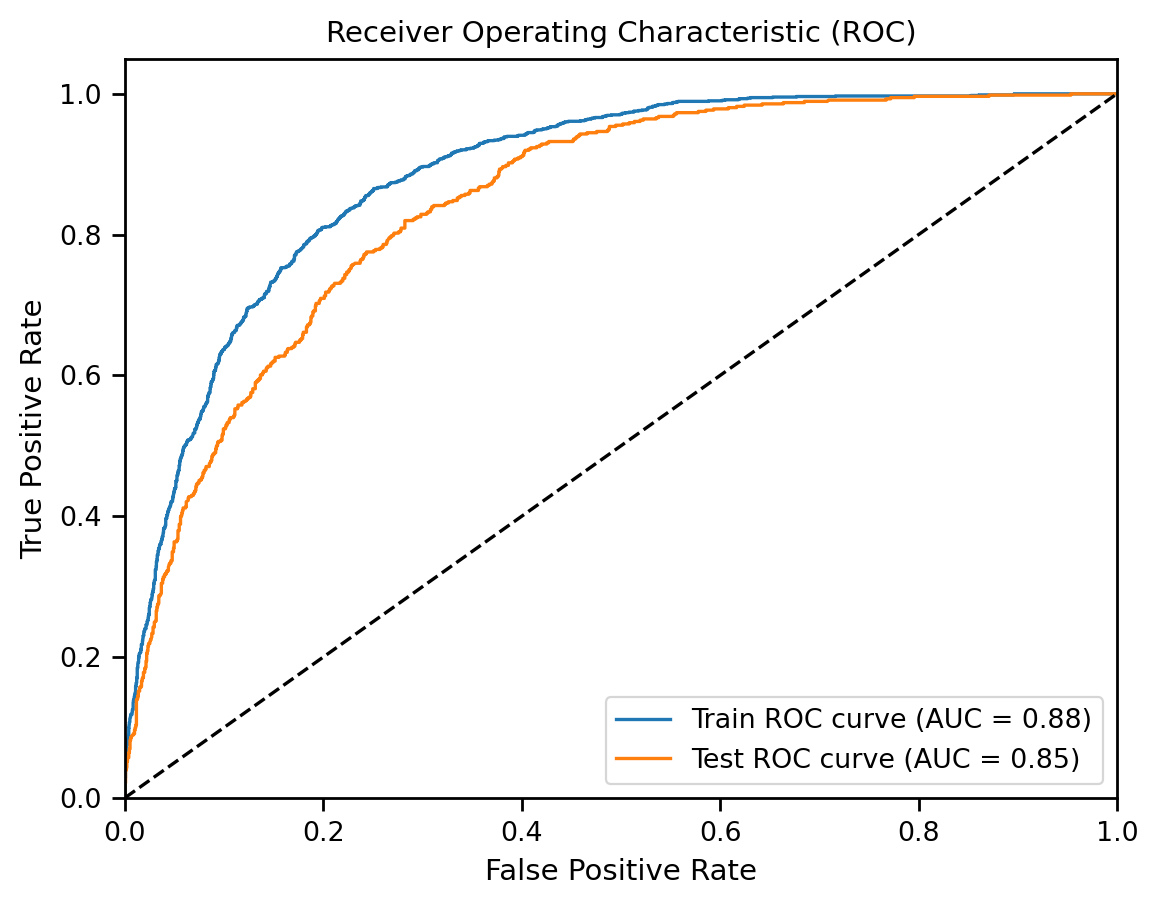

In [310]:
# Train the classifier/model and obtain predicted probabilities
gb.fit(X_train, y_train)
y_train_pred_prob = gb.predict_proba(X_train)[:, 1]
y_test_pred_prob = gb.predict_proba(X_test)[:, 1]

# Calculate ROC AUC scores
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

# Calculate False Positive Rate (fpr), True Positive Rate (tpr), and corresponding thresholds
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)

# Plot ROC curves
plt.plot(fpr_train, tpr_train, label='Train ROC curve (AUC = %0.2f)' % train_roc_auc)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (AUC = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line (diagonal)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Conclusion**

**F1-Score** accuracy of **Gradient Boosting Classifier** at **0.79**

Accuracy of **ROC AUC** on the test set **Gradient Boosting Classifier** is: **0.85**

The result has already reached the expected F1 target score, which is **0.85**.

# **4.8 LightGBM Classifier**

In [311]:
# Create an instance of LGBMClassifier
model_LGBM = LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    num_leaves=31,
    learning_rate=0.05,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5
)

# Train the model
model_LGBM.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_LGBM.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Accuracy: 78.61%


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


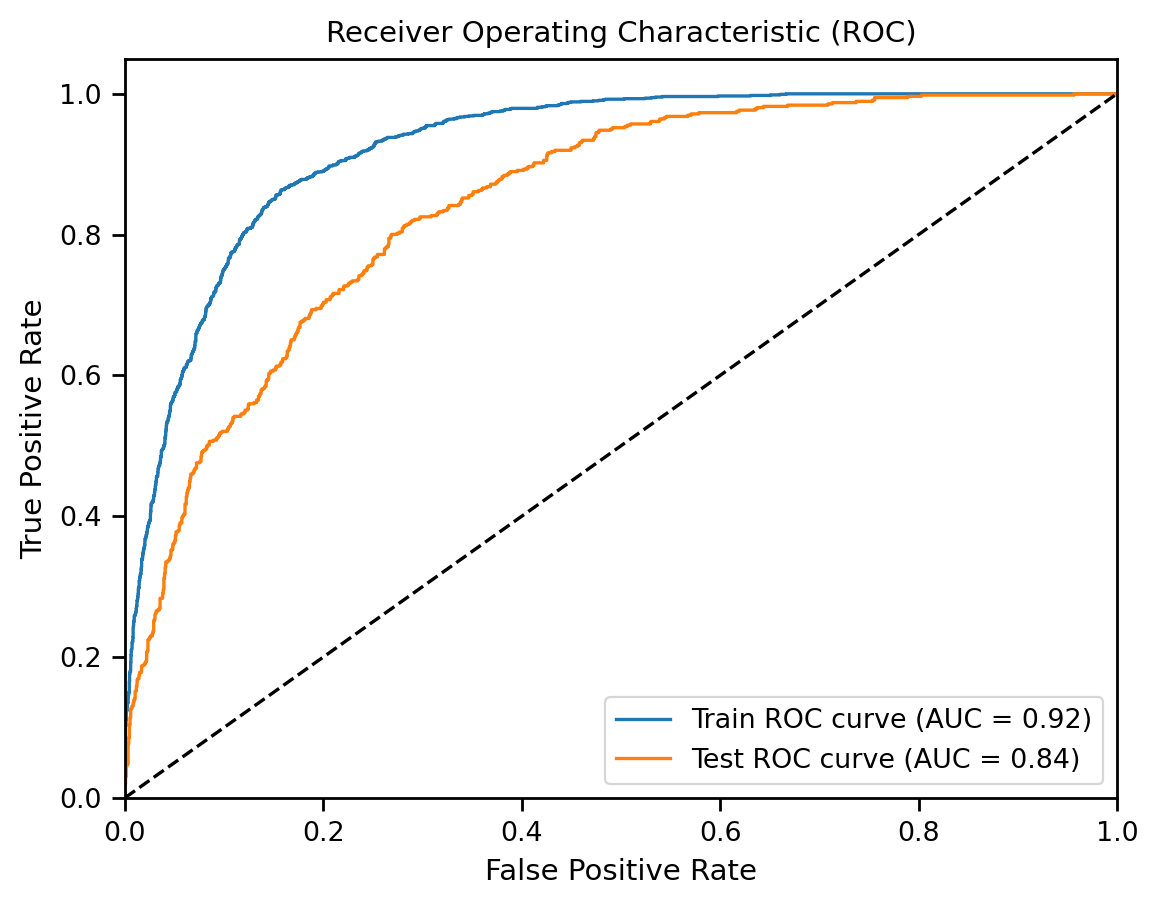

In [312]:
# Train the classifier/model and obtain predicted probabilities
model_LGBM.fit(X_train, y_train)
y_train_pred_prob = model_LGBM.predict_proba(X_train)[:, 1]
y_test_pred_prob = model_LGBM.predict_proba(X_test)[:, 1]

# Calculate ROC AUC scores
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

# Calculate False Positive Rate (fpr), True Positive Rate (tpr), and corresponding thresholds
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)

# Plot ROC curves
plt.plot(fpr_train, tpr_train, label='Train ROC curve (AUC = %0.2f)' % train_roc_auc)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (AUC = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line (diagonal)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Conclusion**

**F1-Score** accuracy of **LightGBM** at **0.79**

Accuracy of **ROC AUC** on the test set **LightGBM** is: **0.84**

The result is below the expected F1 target score, which is **0.85**.

# **4.9 CatBoost Classifier**

In [313]:
# Create CatBoost model
model_CB = CatBoostClassifier()

# Train the model
model_CB.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_CB.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Learning rate set to 0.02036
0:	learn: 0.6769684	total: 10.9ms	remaining: 10.8s
1:	learn: 0.6635287	total: 14.5ms	remaining: 7.21s
2:	learn: 0.6517281	total: 17.6ms	remaining: 5.84s
3:	learn: 0.6395664	total: 22.9ms	remaining: 5.71s
4:	learn: 0.6280725	total: 25.9ms	remaining: 5.16s
5:	learn: 0.6170473	total: 28.8ms	remaining: 4.77s
6:	learn: 0.6074743	total: 31.4ms	remaining: 4.45s
7:	learn: 0.5984694	total: 34.5ms	remaining: 4.28s
8:	learn: 0.5893310	total: 37.5ms	remaining: 4.13s
9:	learn: 0.5819257	total: 40.2ms	remaining: 3.98s
10:	learn: 0.5729532	total: 44.6ms	remaining: 4.01s
11:	learn: 0.5654113	total: 47.2ms	remaining: 3.89s
12:	learn: 0.5583839	total: 49.7ms	remaining: 3.77s
13:	learn: 0.5505570	total: 52.6ms	remaining: 3.7s
14:	learn: 0.5442794	total: 55.7ms	remaining: 3.66s
15:	learn: 0.5376983	total: 58.6ms	remaining: 3.6s
16:	learn: 0.5318345	total: 61.7ms	remaining: 3.56s
17:	learn: 0.5265521	total: 64.4ms	remaining: 3.51s
18:	learn: 0.5212218	total: 67.3ms	remaining: 3

Learning rate set to 0.02036
0:	learn: 0.6769684	total: 4.16ms	remaining: 4.15s
1:	learn: 0.6635287	total: 6.83ms	remaining: 3.41s
2:	learn: 0.6517281	total: 9.7ms	remaining: 3.22s
3:	learn: 0.6395664	total: 12.4ms	remaining: 3.08s
4:	learn: 0.6280725	total: 15.6ms	remaining: 3.09s
5:	learn: 0.6170473	total: 18.2ms	remaining: 3.01s
6:	learn: 0.6074743	total: 20.9ms	remaining: 2.96s
7:	learn: 0.5984694	total: 23.7ms	remaining: 2.94s
8:	learn: 0.5893310	total: 26.7ms	remaining: 2.94s
9:	learn: 0.5819257	total: 29.4ms	remaining: 2.91s
10:	learn: 0.5729532	total: 32.5ms	remaining: 2.92s
11:	learn: 0.5654113	total: 35.6ms	remaining: 2.93s
12:	learn: 0.5583839	total: 38ms	remaining: 2.88s
13:	learn: 0.5505570	total: 40.8ms	remaining: 2.87s
14:	learn: 0.5442794	total: 43.6ms	remaining: 2.86s
15:	learn: 0.5376983	total: 46.6ms	remaining: 2.86s
16:	learn: 0.5318345	total: 49.5ms	remaining: 2.86s
17:	learn: 0.5265521	total: 52.5ms	remaining: 2.86s
18:	learn: 0.5212218	total: 55.4ms	remaining: 2.

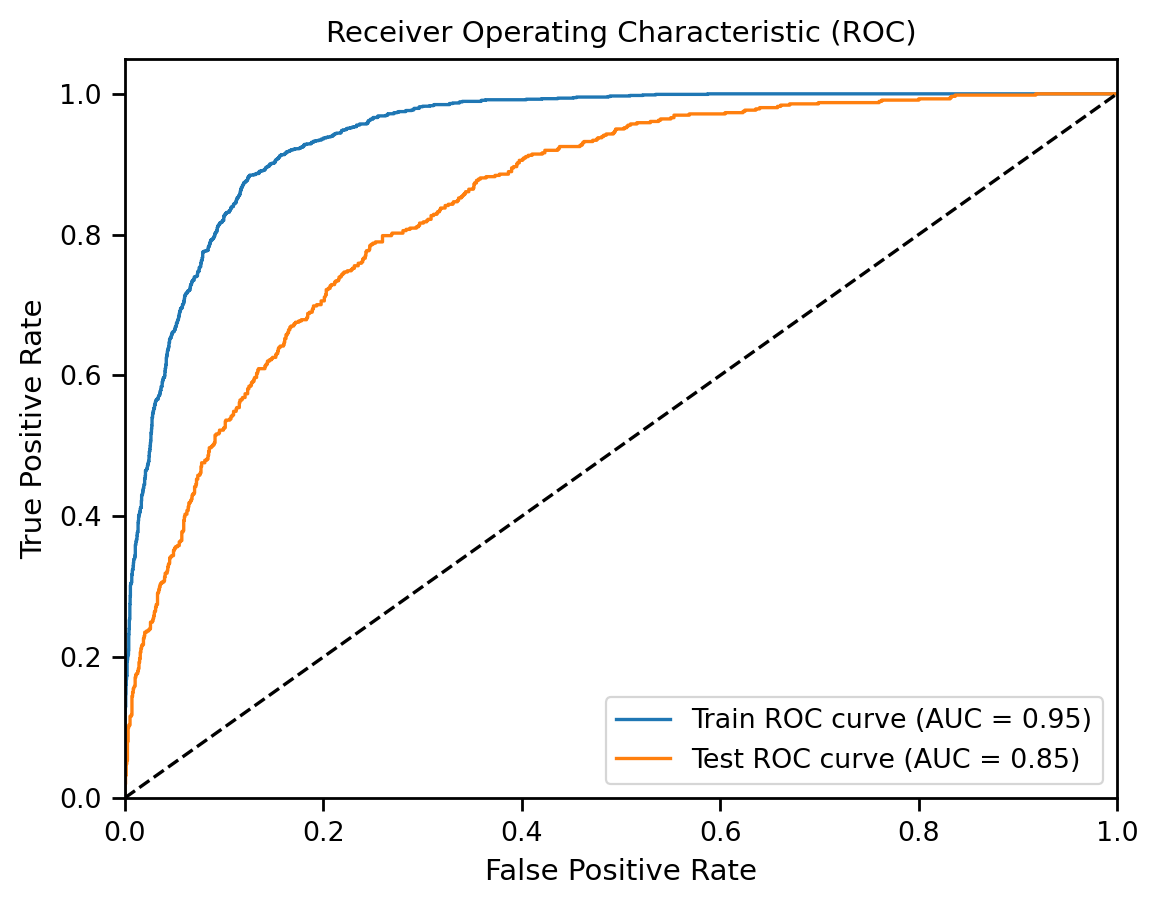

In [314]:
# Train the classifier/model and obtain predicted probabilities
model_CB.fit(X_train, y_train)
y_train_pred_prob = model_CB.predict_proba(X_train)[:, 1]
y_test_pred_prob = model_CB.predict_proba(X_test)[:, 1]

# Calculate ROC AUC scores
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

# Calculate False Positive Rate (fpr), True Positive Rate (tpr), and corresponding thresholds
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)

# Plot ROC curves
plt.plot(fpr_train, tpr_train, label='Train ROC curve (AUC = %0.2f)' % train_roc_auc)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (AUC = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line (diagonal)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Conclusion**

**F1-Score** accuracy **CatBoost** at **0.80**

Accuracy of  **ROC AUC** on the test set **CatBoost** is: **0.85**

The result has already reached the expected F1 target score, which is **0.85**.

# **4.10 Voting Classifier**

In [315]:
clf1 = RandomForestClassifier()
clf2 = GradientBoostingClassifier()
clf3 = CatBoostClassifier()
eclf1 = VotingClassifier(estimators=[('gbc', clf1), ('lr', clf2), ('abc', clf3)], voting='soft')
eclf1.fit(X_train, y_train)
predictions = eclf1.predict(X_test)
print("Final Accuracy Score ")
print(accuracy_score(y_test, predictions))

Learning rate set to 0.02036
0:	learn: 0.6769684	total: 4.86ms	remaining: 4.86s
1:	learn: 0.6635287	total: 7.63ms	remaining: 3.81s
2:	learn: 0.6517281	total: 10.4ms	remaining: 3.46s
3:	learn: 0.6395664	total: 15.7ms	remaining: 3.91s
4:	learn: 0.6280725	total: 20.8ms	remaining: 4.13s
5:	learn: 0.6170473	total: 26.2ms	remaining: 4.34s
6:	learn: 0.6074743	total: 31.4ms	remaining: 4.45s
7:	learn: 0.5984694	total: 34.9ms	remaining: 4.33s
8:	learn: 0.5893310	total: 38ms	remaining: 4.18s
9:	learn: 0.5819257	total: 40.2ms	remaining: 3.98s
10:	learn: 0.5729532	total: 43.2ms	remaining: 3.88s
11:	learn: 0.5654113	total: 46.2ms	remaining: 3.81s
12:	learn: 0.5583839	total: 48.8ms	remaining: 3.71s
13:	learn: 0.5505570	total: 51.7ms	remaining: 3.64s
14:	learn: 0.5442794	total: 54.6ms	remaining: 3.59s
15:	learn: 0.5376983	total: 57.6ms	remaining: 3.54s
16:	learn: 0.5318345	total: 61.4ms	remaining: 3.55s
17:	learn: 0.5265521	total: 64.4ms	remaining: 3.51s
18:	learn: 0.5212218	total: 67.1ms	remaining: 3

In [316]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1552
           1       0.62      0.57      0.59       561

    accuracy                           0.79      2113
   macro avg       0.73      0.72      0.73      2113
weighted avg       0.79      0.79      0.79      2113



Learning rate set to 0.02036
0:	learn: 0.6769684	total: 2.9ms	remaining: 2.9s
1:	learn: 0.6635287	total: 5.93ms	remaining: 2.96s
2:	learn: 0.6517281	total: 8.78ms	remaining: 2.92s
3:	learn: 0.6395664	total: 11.7ms	remaining: 2.9s
4:	learn: 0.6280725	total: 15ms	remaining: 2.99s
5:	learn: 0.6170473	total: 26.3ms	remaining: 4.35s
6:	learn: 0.6074743	total: 31.2ms	remaining: 4.43s
7:	learn: 0.5984694	total: 34.1ms	remaining: 4.23s
8:	learn: 0.5893310	total: 37ms	remaining: 4.08s
9:	learn: 0.5819257	total: 39.5ms	remaining: 3.91s
10:	learn: 0.5729532	total: 42.3ms	remaining: 3.8s
11:	learn: 0.5654113	total: 45.3ms	remaining: 3.73s
12:	learn: 0.5583839	total: 47.6ms	remaining: 3.62s
13:	learn: 0.5505570	total: 50.1ms	remaining: 3.53s
14:	learn: 0.5442794	total: 52.9ms	remaining: 3.47s
15:	learn: 0.5376983	total: 55.8ms	remaining: 3.43s
16:	learn: 0.5318345	total: 58.7ms	remaining: 3.39s
17:	learn: 0.5265521	total: 61.5ms	remaining: 3.36s
18:	learn: 0.5212218	total: 64.4ms	remaining: 3.33s
1

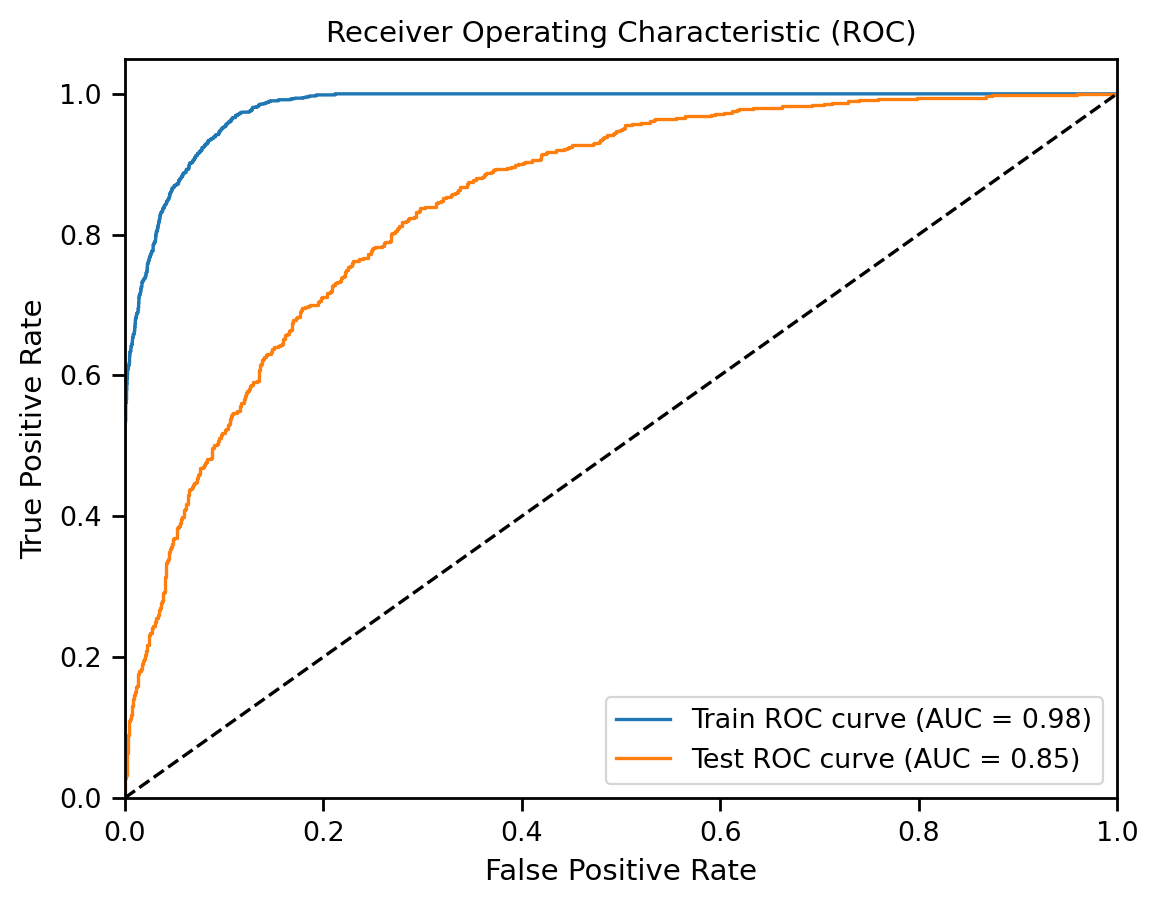

In [317]:
# Train the classifier/model and obtain predicted probabilities
eclf1.fit(X_train, y_train)
y_train_pred_prob = eclf1.predict_proba(X_train)[:, 1]
y_test_pred_prob = eclf1.predict_proba(X_test)[:, 1]

# Calculate ROC AUC scores
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

# Calculate False Positive Rate (fpr), True Positive Rate (tpr), and corresponding thresholds
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)

# Plot ROC curves
plt.plot(fpr_train, tpr_train, label='Train ROC curve (AUC = %0.2f)' % train_roc_auc)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (AUC = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line (diagonal)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Conclusion**

**F1-Score** accuracy of **Voting Classifier** at **0.80**

Accuracy of **ROC AUC** on the test set **Voting Classifier** is: **0.85**

The result has already reached the expected F1 target score, which is **0.85**.

# **5. Final Conclusion**

# **5.1 Conclusion**

A telecom operator called Interconnect wanted to forecast their 'customers' churn rate. If its known that a client is planning to quit, ths customer will be offered a promotional code and special package options. Interconnect's marketing team has collected some personal data from ccustomers, including information about selected data plans and their contracts.

In the preparation stage we get 4 datasets, as follows:
1. `contract.csv` — contract information
2. `personal.csv` — client personal data
3. `internet.csv` — information about Internet services
4. `phone.csv` — information about phone services

And then we check each dataset, and join into one complete dataset with name `df_final_provider`. This dataset contains customer data information and services they use at a telecommunications operator Interconnect. This dataset has 20 columns and 7043 rows of data. In this case we perform an analysis using several machine learning models to help Interconnect find solutions to encounter their problems. After we check the given dataset, then we perform the data analysis. This time we use several models to find the best results.

After we carry out the plot above, it appears that some of the trends that we can analyze as follows:

- Based on data visualization `distribution chart between Gender and Churn`, there is around 26.5% of customers are moving to another provider. From the total customers who moved to other providers, around 49.5% were female customers and 50.5% were male customers. This may be caused by service that are not optimized by Interconnect provider to their customers.
- Based on data visualization `chart to see the pattern of churn distribution on Gender M/F`, there are differences in the percentage/calculation of customers who have changed service providers. Both men and women have a similar pattern when migrating to other providers.
- Based on data visualization `histogram to see the distribution of Contract Type data used by Customer`, Approximately **75%** customers with `Month-to-Month` contract type choose to switch to another provider when compared to **13%** customers with the `One Year` contract type, and **3%** with the `Two Year` contract type. It might be caused by the customer who wants to see how far the quality is provided by the Interconnect if they choose a prepaid contract. It is possible that customers also consider the losses they will get if the services provided by the Interconnect  do not match their expectations on long-term contracts.
- Based on data visualization `Distribution histogram of Customer Payment Method against Churn`. The majority of customers who have switched to other providers were used the **Payment Method** with `Electronic Check` type. Customers who use the **Payment Method** with `Credit-Card (automatic)` or `Bank transfer (automatic)` type, and `Mailed check` have less tendency to switch to another provider.
- Based on the `Barchart for Churn Distribution against Internet Service and Gender` visualization data. There are many customers who choose `InternetService` with the `Fiber optic` type and this also proves that customers who use `Fiber optic` have a **high churn rate**, this may be due to customer dissatisfaction with the service. Customers who use `InternetService` with `DSL` type have the largest number of customers, and have a **low churn rate** in compared to `Fiber optic` services.

Then, we separate the train / test set with some data manipulation, because the numeric features are distributed over a different range of values, so in this case we will use the standard scalar to scale down so they will adjusted to the same range. We seperated the fields into 3 categories, one for standardization, one for label encoding, and one for OHE

We create a machine learning model. We use several models, as follows:
- 4.1 KNN
- 4.2 SVC
- 4.3 Random Forest
- 4.4 Logistic Regression
- 4.5 Decision Tree Classifier
- 4.6 AdaBoost Classifier
- 4.7 Gradient Boosting Classifier
- 4.8 LightGBM Classifier
- 4.9 Catboost Classifier
- 4.10 Voting Classifier

After we proceed the above machine learning model, we get the following results:
- **The lowest score** is in the **Decision Tree Classifier** model, with accuracy of **F1-Score** at **0.74**. And the accuracy of **ROC AUC** on the test set produced by the Decision Tree Classifier is: **0.69**

- The **highest score** are found in the following models:
   - **RandomForestClassifier** --- with an accuracy of **F1-Score** at **0.80**. And the accuracy of **ROC AUC** in the test set produced by the Gradient Boosting Classifier is: **0.85**
   - **GradientBoostingClassifier** --- with an accuracy of **F1-Score** at **0.79**. And the accuracy of **ROC AUC** in the test set produced by the Gradient Boosting Classifier is: **0.85**
   - **CatBoostClassifier** --- with an accuracy of **F1-Score** at **0.80**. And the accuracy of **ROC AUC** in the test set produced by the Cat Boost Classifier is: **0.85**


In the final model `Voting Classifier`, this model is a combination of 3 models with the highest ROC AUC accuracy results in the model that we have run before; **RandomForestClassifier**, **GradientBoostingClassifier**, **CatBoostClassifier**.

After we run the `Voting Classifier`, we get results with an accuracy of **F1-Score** at **0.80**. And the accuracy of **ROC AUC** on the test set is: **0.85**

The result has already reached the expected F1 target score, which is **0.85**.

Customer churn is clearly bad for company profitability. There are various strategies that can be implemented to eliminate customer churn. The best way to avoid customer churn is to use KYC, this method need to be done so the company can get to know their customers better. It includes identify customers who are at risk of become churned, and for the company they need to increase their customers satisfaction. To improve customer service is, of course, a top priority to address this issue.
Building customer loyalty through relevant experiences and customized services is an alternative strategy to reduce customer churn. Some companies have conducted surveys of customers churn to understand why they are no longer using the company's services in order to adopt a proactive approach to avoid future customer churn.

# **Project Plan**

**1. Load Data**
  - [x] 1.1 Review Data Contents
  - [x] 1.2 Ensure the data type is correct
  - [x] 1.3 Join all tables into a dataset
  - [x] 1.4 Check and fill the missing value
  - [x] 1.5 Feature Selection

**2. Exploratory Data Analysis**
  - [x] 2.1 Distribution chart between Gender and Churn
  - [x] 2.2 Create a chart to see the pattern of churn distribution on Gender M/F
  - [x] 2.3 Create a histogram to see the distribution of Contract Type data used by Customer
  - [x] 2.4 Piechart for distribution of Payment Methods
  - [x] 2.5 Distribution histogram of Customer Payment Method against Churn
  - [x] 2.6 Barchart for Churn Distribution against Internet Service and Gender
  - [x] 2.7 Histogram for Churn Distribution against Dependents
  - [x] 2.8 Histogram for Churn Distribution against Partners
  - [x] 2.9 Histogram for Churn Distribution against Senior Citizens
  - [x] 2.10 Histogram for Churn Distribution against Online Security
  - [x] 2.11 Histogram for Churn Distribution against Paperless Billing
  - [x] 2.12 Histogram for Churn Distribution against TechSupport
  - [x] 2.13 Histogram for Churn Distribution against OnlineBackup
  - [x] 2.14 Histogram for Churn Distribution against DeviceProtection
  - [x] 2.15 Histogram for Churn Distribution against StreamingTV
  - [x] 2.16 Histogram for Churn Distribution against StreamingMovies
  - [x] 2.17 Histogram for Churn Distribution against MultipleLines
  - [x] 2.18 Kdeplots for distribution of monthly charges at churn
  - [x] 2.19 Kdeplot for distribution of total charges at churn

**3. Data Preprocessing**
 - [x] 3.1 Split the dataset into train set and test set
 - [x] 3.2 Standardize numeric attributes

**4. Machine Learning**
 - [x]  4.1 KNN
 - [x]  4.2 SVC
 - [x]  4.3 Random Forest
 - [x]  4.4 Logistic Regression
 - [x]  4.5 Decision Tree Classifier
 - [x]  4.6 AdaBoost Classifier
 - [x]  4.7 Gradient Boosting Classifier
 - [x]  4.8 LightGBM Classifier
 - [x]  4.9 Catboost Classifier
 - [x]  4.10 Voting Classifier

**5. Final Conclusion**
 - [x]  5.1 Conclusion
